# Анализ данных по ДТП в Волгоградской области


Содержание работы:
* Знакомство с данными
* Очитка данных
* Классификация данных по географическим координатам  
  выбор наилучшего метода из иерархическая, k-means++, DBScan
  и интерпретация результата
* Анализ тяжести ДТП от погодных условий  
  методом логистической регрессии и  
  методом многослойного перцептрона (с подбором гиперпараметров сети)
* Создание Телеграм-бота для предсказания тяжести ДТП при условии её возникновения

# Загрузим данные

Данные взяты с сайта 
https://dtp-stat.ru/opendata

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap

In [3]:
# Данные по Волгоградской области взяты с сайта https://dtp-stat.ru/opendata в формате geojson
geo_dtp_data = gpd.read_file('https://cms.dtp-stat.ru/media/opendata/volgogradskaia-oblast.geojson') # ~40M
geo_dtp_data = geo_dtp_data.set_index('id')
geo_dtp_data.head(3)

light  \
id                                                     
2720133                          Светлое время суток   
2655081                          Светлое время суток   
2655084  В темное время суток, освещение отсутствует   

                                         point  \
id                                               
2720133  {'lat': 48.399007, 'long': 42.123256}   
2655081  {'lat': 48.058305, 'long': 42.376692}   
2655084  {'lat': 48.391983, 'long': 42.322276}   

                                                    nearby         region  \
id                                                                          
2720133                                                [ ]  Чернышковский   
2655081  [ "Нерегулируемый перекрёсток неравнозначных у...  Чернышковский   
2655084                                                [ ]  Чернышковский   

        scheme                                            address  \
id                                                                  
2720133    200  А-260 Волгоград - Каменск-Шахтинский - граница...   
2655081    500  А/д Цимлянск - Нижнегнутов - Чернышковский (в ...   
2655084    610                                               None   

               category            datetime     severity  \
id                                                         
2720133    Столкновение 2022-05-22 16:10:00  С погибшими   
2655081    Столкновение 2021-11-19 11:35:00      Тяжёлый   
2655084  Съезд с дороги 2021-11-03 02:30:00      Тяжёлый   

                                                  vehicles  dead_count  \
id                                                                       
2720133  [ { "year": 2010, "brand": "ВАЗ", "color": "Си...           1   
2655081  [ { "year": 2020, "brand": "ВАЗ", "color": "Че...           0   
2655084  [ { "year": 2002, "brand": "ВАЗ", "color": "Се...           0   

        participants  injured_count          parent_region  \
id                                                           
2720133          [ ]              3  Волгоградская область   
2655081          [ ]              2  Волгоградская область   
2655084          [ ]              2  Волгоградская область   

         participants_count                   geometry  
id                                                      
2720133                   4  POINT (42.12326 48.39901)  
2655081                   2  POINT (42.37669 48.05830)  
2655084                   2  POINT (42.32228 48.39198)

In [4]:
geo_dtp_data.describe()

dead_count  injured_count  participants_count
count  20077.000000   20077.000000        20077.000000
mean       0.117199       1.286746            2.512776
std        0.386128       0.908117            1.247671
min        0.000000       0.000000            1.000000
25%        0.000000       1.000000            2.000000
50%        0.000000       1.000000            2.000000
75%        0.000000       1.000000            3.000000
max        8.000000      21.000000           54.000000

Пробуем визуализировать данные

In [5]:
# Использую код со станицы проекта geopandas
# Для наложения координат на карту нужно сконвертировать координаты
geo_dtp_data_wm = geo_dtp_data.to_crs(epsg=3857)

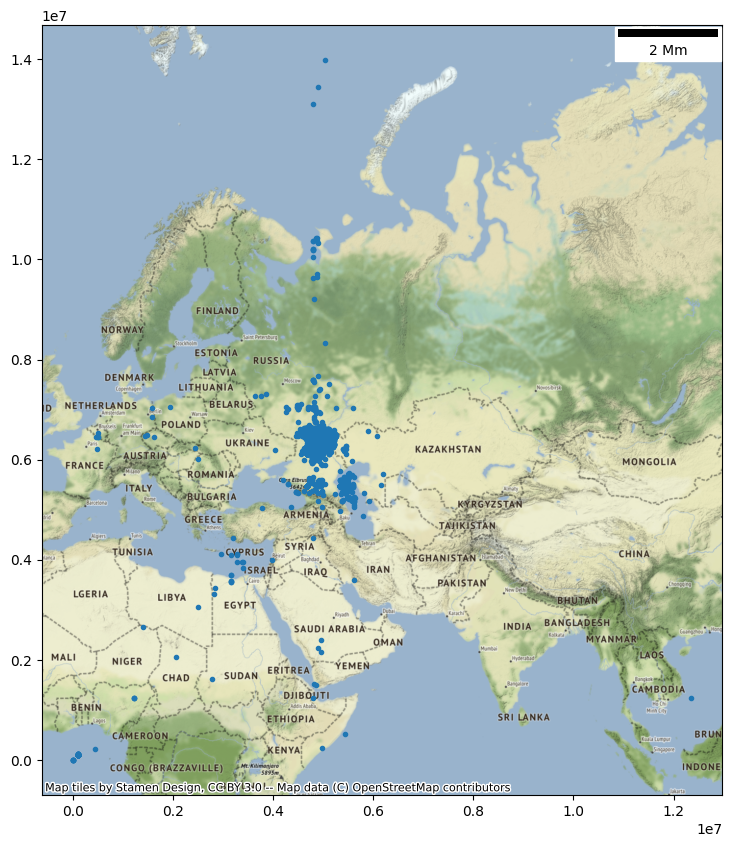

In [6]:
ax = geo_dtp_data_wm.plot(figsize=(10,10), marker='.')
ax.add_artist(ScaleBar(1)) # выводит масштаб
cx.add_basemap(ax) # делает подложку карты

## Очистка данных

Видим, что присутвуют некорректные геоданыые - выбросы. Избавимся от них.  
Для этого отсечём данные, выходящие за границы волгоградкой области.  
Границы области берём с проекта openstreetmap, используя API, по ссылке https://nominatim.openstreetmap.org/search?format=geojson&q=Волгоградская%20область&polygon_geojson=1 . Сохраним полученный файл на диск в формате geojson

<AxesSubplot: >

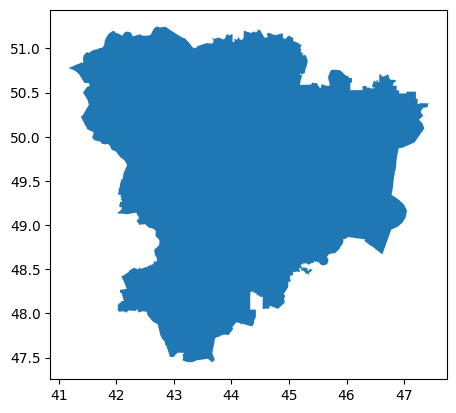

In [7]:
# Вариант с загрузкой из интернет
import requests
url = ('https://nominatim.openstreetmap.org/search?format=geojson&q=Волгоградская%20область&polygon_geojson=1')
vlg_obl_gdf = gpd.read_file(requests.get(url).content.decode("UTF-8"))

vlg_obl_gdf.plot()

In [8]:
# Ещё посмотрим что у нас получится с выделением городов
url = ('https://nominatim.openstreetmap.org/search?format=geojson&q=город%20Волгоградская%20область&polygon_geojson=1')
vlg_obl_cities_gdf = gpd.read_file(requests.get(url).content.decode("UTF-8"))


<AxesSubplot: >

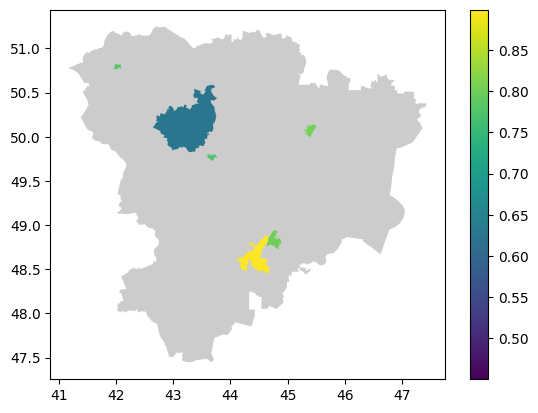

In [9]:
# Визуализируем области (шкала важности)
fig, ax = plt.subplots(1, 1)
vlg_obl_gdf.plot(color='0.8',ax=ax)
vlg_obl_cities_gdf.plot(column='importance', ax=ax, legend=True)

Видно, что города вывелись не все и не соответвует крупность городов. Далее не используем.

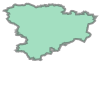

In [10]:
# Выделим полигон с Волгоградкой областью, по которому будем отсекать данные
vlg_obl_polygon = vlg_obl_gdf['geometry'].iloc[0]
vlg_obl_polygon 


In [11]:
# Отсечём данные и посмотрим сколько данных получили на выходе
geo_dtp_data_clipped = geo_dtp_data.clip(vlg_obl_polygon)
print(f'Отбраковали {geo_dtp_data.shape[0] - geo_dtp_data_clipped.shape[0]} записей')
print(f'Осталось {geo_dtp_data_clipped.shape[0]} записей')

Отбраковали 766 записей
Осталось 19311 записей


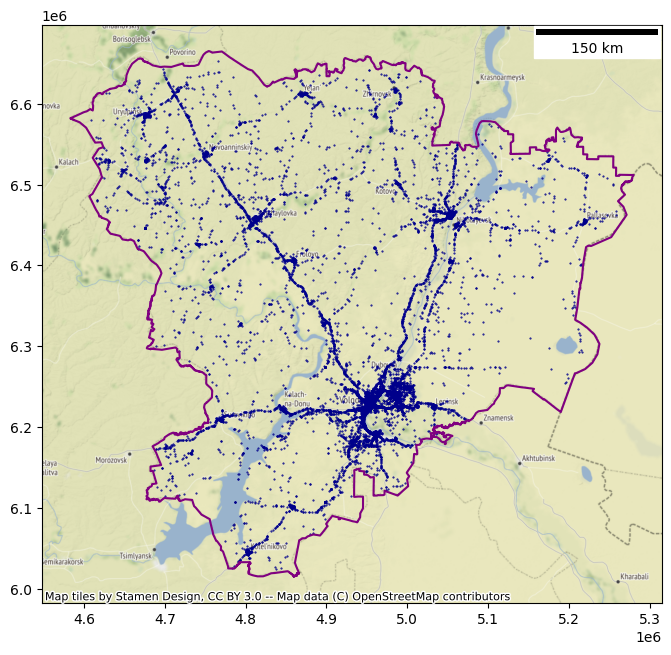

In [12]:
# Теперь визуализируем полученныей результат
fig, ax = plt.subplots(figsize=(8, 8))
vlg_obl_gdf_wm = vlg_obl_gdf.to_crs(epsg=3857)
geo_dtp_data_wm = geo_dtp_data_clipped.to_crs(epsg=3857)
geo_dtp_data_wm.plot(ax=ax, marker='.', markersize=1, c='darkblue')
vlg_obl_gdf_wm.boundary.plot(ax=ax, color='purple')
ax.add_artist(ScaleBar(1)) # выводит масштаб
cx.add_basemap(ax)

Отлично! Едем дальше

## Предварительный/визуальный анализ данных

Теперь смотрим что у нас данными

In [12]:
geo_dtp_data_clipped.head(3)

light  \
id                                                     
2733815  В темное время суток, освещение отсутствует   
2566738  В темное время суток, освещение отсутствует   
2600047                                      Сумерки   

                                         point           region scheme  \
id                                                                       
2733815   {'lat': 47.51123, 'long': 42.973022}  Котельниковский    840   
2566738  {'lat': 47.628206, 'long': 43.228884}  Котельниковский    600   
2600047   {'lat': 47.62877, 'long': 43.188447}  Котельниковский    600   

                                                   address           category  \
id                                                                              
2733815  Автомобильная дорога Волгоград - Октябрьский -...  Наезд на пешехода   
2566738                                               None     Съезд с дороги   
2600047                                               None      Опрокидывание   

                   datetime     severity  \
id                                         
2733815 2022-07-04 22:15:00  С погибшими   
2566738 2021-04-19 18:30:00      Тяжёлый   
2600047 2021-07-24 04:25:00  С погибшими   

                                                  vehicles  dead_count  \
id                                                                       
2733815  [ { "year": null, "brand": null, "color": "Чер...           1   
2566738  [ { "year": 2010, "brand": "ВАЗ", "color": "Си...           0   
2600047  [ { "year": 2003, "brand": "DAEWOO", "color": ...           1   

                                              participants  injured_count  \
id                                                                          
2733815  [ { "role": "Пешеход", "gender": "Мужской", "v...              0   
2566738                                                [ ]              1   
2600047                                                [ ]              0   

                 parent_region  participants_count                   geometry  
id                                                                             
2733815  Волгоградская область                   2  POINT (42.97302 47.51123)  
2566738  Волгоградская область                   2  POINT (43.22888 47.62821)  
2600047  Волгоградская область                   1  POINT (43.18845 47.62877)

Данные имеют следующую структуру (данные из источника)
```
{
    "id": 384094,                                   # идентификатор
    "tags": ["Дорожно-транспортные происшествия"],  # показатели с официального сайта ГИБДД
    "light": "Светлое время суток",                 # время суток
    "point": {"lat": 50.6039, "long": 36.5578},     # координаты
    "nearby": [ "Нерегулируемый перекрёсток неравнозначных улиц (дорог)", "Жилые дома индивидуальной застройки"], # координаты
    "region": "Белгород",                           # город/район
    "address": "г Белгород, ул Сумская, 30",        # адрес
    "weather": ["Ясно"],                            # погода
    "category": "Столкновение",                     # тип ДТП
    "datetime": "2017-08-05 13:06:00",              # дата и время
    "severity": "Легкий",                           # тяжесть ДТП/вред здоровью
    "vehicles": [                                   # участники – транспортные средства
      {
        "year": 2010,                               # год производства транспортного средства
        "brand": "ВАЗ",                             # марка транспортного средства
        "color": "Иные цвета",                      # цвет транспортного средства
        "model": "Priora",                          # модель транспортного средства
        "category": "С-класс (малый средний, компактный) до 4,3 м", # категория транспортного средства
        "participants": [                           # участники внутри транспортных средств
          {
            "role": "Водитель",                     # роль участника
            "gender": "Женский",                    # пол участника
            "violations": [],                       # нарушения правил участником
            "health_status": "Раненый, находящ...", # состояние здоровья участника
            "years_of_driving_experience": 11       # стаж вождения участника (только у водителей)
          }
        ]
      },
    ],
    "dead_count": 0,                                # кол-во погибших в ДТП
    "participants": [],                             # участники без транспортных средств
                                                    # (описание, как у участников внутри транспортных средств)
    "injured_count": 2,                             # кол-во раненых в ДТП
    "parent_region": "Белгородская область",        # регион
    "road_conditions": ["Сухое"],                   # состояние дорожного покрытия
    "participants_count": 3,                        # кол-во участников ДТП
    "participant_categories": ["Все участники", "Дети"] # категории участников
  }
  ```

In [13]:
# Закоментировал, потому-что долго идёт просчёт
# geo_dtp_data_clipped.describe(datetime_is_numeric=True, include = "all")

![geo_dtp_data_clipped.describe](geo_dtp_data_clipped.describe.png)

In [14]:
geo_dtp_data_clipped.shape

(18780, 15)

In [15]:
geo_dtp_data_clipped.isna().sum()

light                    0
point                    0
region                   0
scheme                1245
address               1794
category                 0
datetime                 0
severity                 0
vehicles                 0
dead_count               0
participants             0
injured_count            0
parent_region            0
participants_count       0
geometry                 0
dtype: int64

Имеем пропущенные данные в столбцах sheme и adress. Столбец sheme не имеет описания. Столбец adress пока не используем в анализе.

По описанию стобцов уже видно, что в данных присутвует классификация по тяжести. Сразу отобразим на карте.

In [16]:
# Создадим градиент для отображения классов
cmap = ListedColormap(["darkblue", 'salmon',"red"])

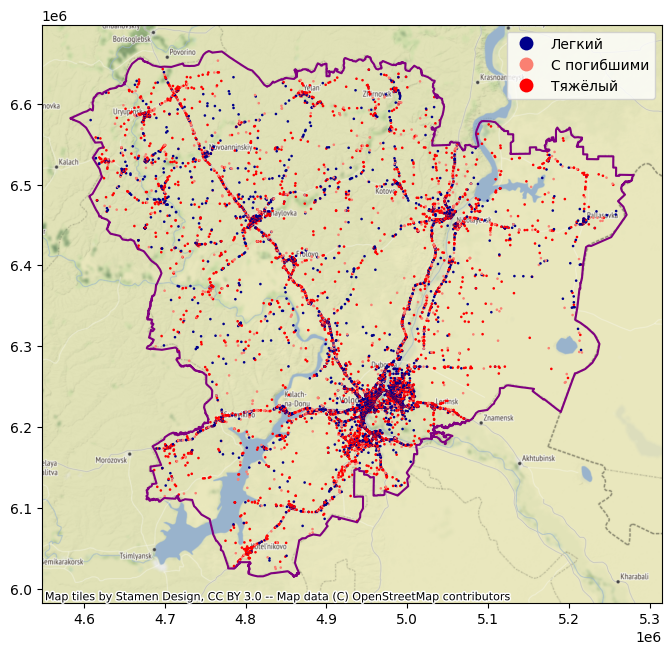

In [17]:
# Теперь визуализируем полученныей результат
fig, ax = plt.subplots(figsize=(8, 8))
vlg_obl_gdf_wm = vlg_obl_gdf.to_crs(epsg=3857)
geo_dtp_data_wm = geo_dtp_data_clipped.to_crs(epsg=3857)
geo_dtp_data_wm.plot(ax=ax, marker='.', markersize=3, column='severity', cmap=cmap, legend=True)
vlg_obl_gdf_wm.boundary.plot(ax=ax, color='purple')
# ax.add_artist(ScaleBar(1)) # выводит масштаб
cx.add_basemap(ax)

Визуально не наблюдается взаимосвязь тяжести ДТП от метоположения: Трасса город, посёлок. Распределение приблизительно равномерное. 

In [18]:
# Создадим градиент для отображения классов
cmap = ListedColormap(['0.5', '0.35', '0', '1', '0.8'])

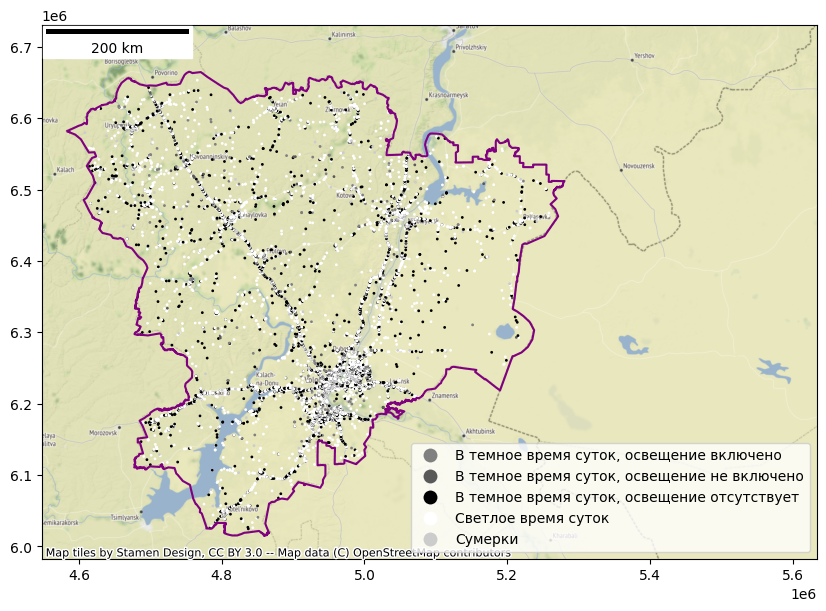

In [19]:
# Теперь визуализируем полученныей результат
fig, ax = plt.subplots(figsize=(10, 10))
vlg_obl_gdf_wm = vlg_obl_gdf.to_crs(epsg=3857)
geo_dtp_data_wm = geo_dtp_data_clipped.to_crs(epsg=3857)
geo_dtp_data_wm.plot(ax=ax, marker='.', markersize=4, column='light', cmap=cmap, legend=True)
vlg_obl_gdf_wm.boundary.plot(ax=ax, color='purple')
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]*1.06)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.005)
ax.add_artist(ScaleBar(1,location='upper left')) # выводит масштаб
cx.add_basemap(ax)

Класс "освещение" визуально не коррелирует с местоположение ДТП

(array([ 2158.,   535., 11811.,  4037.,   239.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

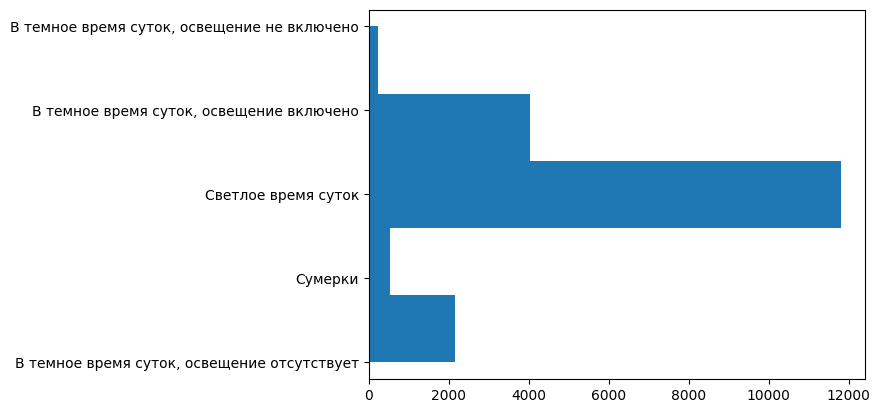

In [20]:
plt.hist(geo_dtp_data_clipped[['light']], orientation='horizontal', bins=5)

Видим, что в тёмное время суток есть фракции. Стожим их и подсчитаем пропорцию ДТП в тёмное время суток и в светлое.

In [21]:
(t:=2158 + 535 +  4037 + 239), 11811, 11811/t

(6969, 11811, 1.69479121825226)

### Вывод
Итого получается не ожиданная картина. Оказывается ДТП происходят в 1.69 раз чаще в светлое время суток.

Посмотрим как визуализируются класс регионов

In [22]:
# Создадим контрастный градиент для отображения классов на карте
import matplotlib.colors as mcolors
from random import seed, shuffle

42


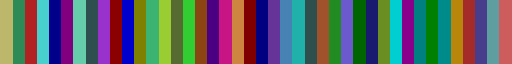

In [23]:
# выбрать из коллекции цветов тёмные и насыщенные цвета
cmap = mcolors.CSS4_COLORS.copy()
drop_keys = [key for key, val in cmap.items()
                if mcolors.rgb_to_hsv(mcolors.to_rgb(val))[2] > 0.82
                    or mcolors.rgb_to_hsv(mcolors.to_rgb(val))[1]<0.25
            ]
for k in drop_keys:
    cmap.pop(k)
print(len(cmap))
seed(123456)
shuffle(cmap:=list(cmap.values()))
cmap = mcolors.ListedColormap(cmap)
cmap

In [24]:
cmap = mcolors.ListedColormap(["olive", "darkblue", "darkmagenta", "orangered", 'darkcyan', 'darkred', 'darkgreen', 'brown', 'indigo', 'crimson', 'red']*5)
cmap = mcolors.ListedColormap(mcolors.CSS4_COLORS.values())

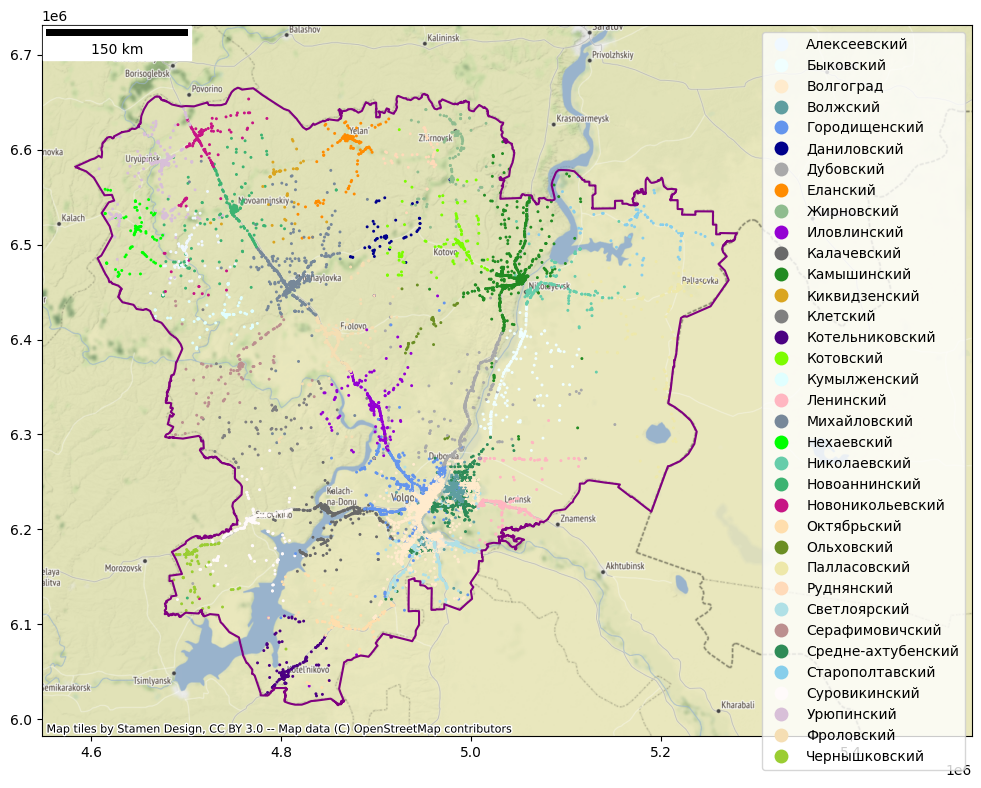

In [25]:
# Теперь визуализируем полученныей результат
fig, ax = plt.subplots(figsize=(12, 12))
vlg_obl_gdf_wm = vlg_obl_gdf.to_crs(epsg=3857)
geo_dtp_data_wm = geo_dtp_data_clipped.to_crs(epsg=3857)
geo_dtp_data_wm.plot(ax=ax, marker='.', markersize=5, column='region', cmap=cmap, legend=True)
vlg_obl_gdf_wm.boundary.plot(ax=ax, color='purple')
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]*1.04)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.005)
ax.add_artist(ScaleBar(1,location='upper left')) # выводит масштаб
cx.add_basemap(ax)

Районы области выделены по административным границам. Само по себе такое деление не очень интересно. Хотелось бы посмотреть концентрацию ДТП. Выявить те места, где аварии происходят наиболее часто. 

## Классификация территориальной концентрации ДТП

Для классификациии, вероятно более подходит метод DBSACAN, потому что форма кластера может быть любой: вытянутой - дороги, круглые скопления - города. Но посмотрим и другие методы.

Подготовим данные. Нам нужны только координаты, которые мы будем рассматривать на евклидовой метрике

In [26]:
X = pd.DataFrame([pd.Series(geo_dtp_data_clipped['point'].iloc[i]) for i in range(len(geo_dtp_data_clipped))], index=geo_dtp_data_clipped.index)
print(X.shape)
X.head()

(18780, 2)


lat       long
id                           
2733815  47.511230  42.973022
2566738  47.628206  43.228884
2600047  47.628770  43.188447
2459739  47.628831  43.182298
2468014  47.628889  43.181389

### Методом иерархической кластеризации

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [28]:
# Произведем иерархическую кластеризацию. Для определения расстояния между кластерами будем использовать метод Варда.
# Построим график каменистой осыпи для определения числа кластеров.
link = linkage(X, 'ward', 'euclidean')
dist = link[:, 2][::-1]
idxs = range(1, len(dist) + 1)

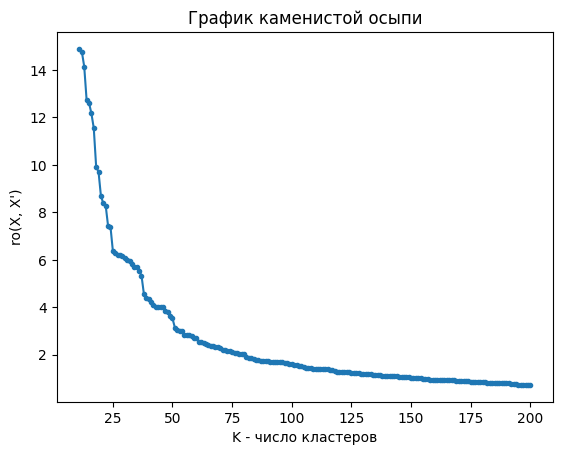

In [29]:
#Рассмотрим количество кластеров от 10 случаи до 100
rock_line = pd.DataFrame()
rock_line['K - число кластеров'] = idxs[10:200]
rock_line["ro(X, X')"] = dist[10:200]
plt.plot(rock_line['K - число кластеров'], rock_line["ro(X, X')"], marker='.')
plt.xlabel('K - число кластеров')
plt.ylabel("ro(X, X')")
plt.title('График каменистой осыпи')
plt.show()

Логически мы хотим разделить на количество поселений. Максимальный скачёк виден на 50 классах

In [30]:
# Построение дендрограммы происходит очень долго и не даёт практического применения.
# Поэтому код закомментирован, но результат представлен на картинке ниже.

# fig_1 = plt.figure(figsize=(12,12))
# dn = dendrogram(link,
#                 color_threshold=dist[4],
#                 orientation = "right",
#                 leaf_rotation=0.)

<img src="src/dendragarmm_output.png" width=512>

In [31]:
#Добавим в данные графу "кластер" и посмотрим
coord_clusters = X.copy()
coord_clusters['Сluster'] = fcluster(link, 50, criterion='maxclust')

In [32]:
silhouette_score(X, coord_clusters['Сluster'])

0.4859022396176657

In [33]:
# Создадим контрастный градиент для отображения классов
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["olive", "darkblue", "darkmagenta", "orangered", 'darkcyan', 'darkred', 'darkgreen', 'brown', 'indigo', 'crimson']*5)

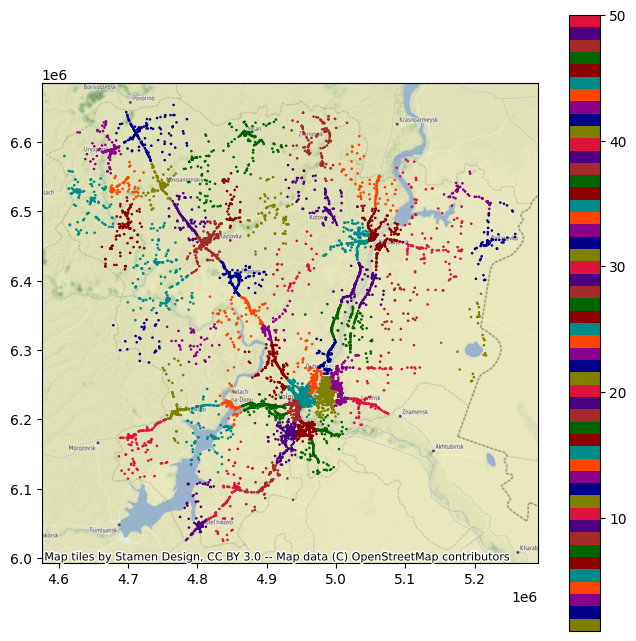

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
coord_clusters_wm = gpd.GeoDataFrame(geo_dtp_data_clipped['geometry'])
coord_clusters_wm = coord_clusters_wm.to_crs(epsg=3857)
coord_clusters_wm['Сluster'] = fcluster(link, 50, criterion='maxclust')
coord_clusters_wm.plot(ax=ax, marker='.', column='Сluster', legend=True, cmap=cmap, markersize=3)
cx.add_basemap(ax)

In [35]:
#Добавим в данные графу "кластер" и посмотрим
coord_clusters = X.copy()
coord_clusters['Сluster'] = fcluster(link, 25, criterion='maxclust')

In [36]:
silhouette_score(X, coord_clusters['Сluster'])

0.4982606728547655

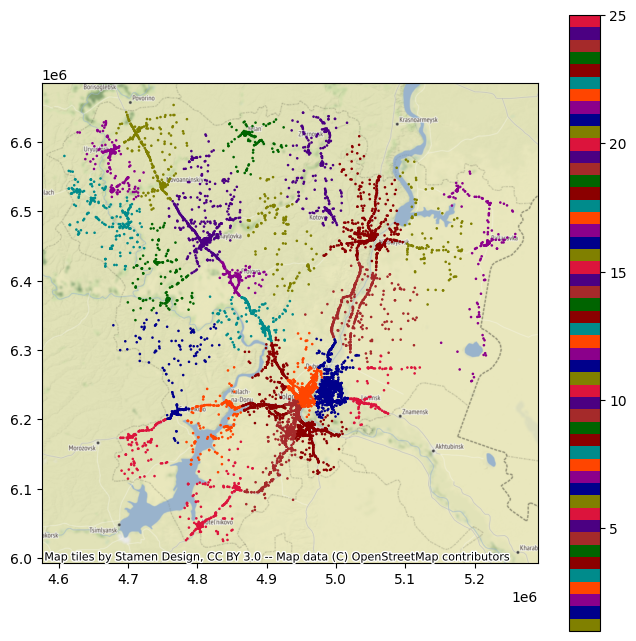

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
coord_clusters_wm = gpd.GeoDataFrame(geo_dtp_data_clipped['geometry'])
coord_clusters_wm = coord_clusters_wm.to_crs(epsg=3857)
coord_clusters_wm['Сluster'] = fcluster(link, 25, criterion='maxclust')
coord_clusters_wm.plot(ax=ax, marker='.', column='Сluster', legend=True, cmap=cmap, markersize=3)
cx.add_basemap(ax)

25 кластеров визкльно лучше ложатся на карту и имею более лучший силуэт.

Выделились крупные города и выходящие из них артерии.  
Областной центра разделился на три класса. Что очень может быть ввиду разделения районов города перешейками. Так же выделяется город Волжский, который находится через реку от Волгограда.

В общем не плохо, но есть множество классов с рассеянными точками. Их надо как-то объединять в один класс.

### Методом k-means++

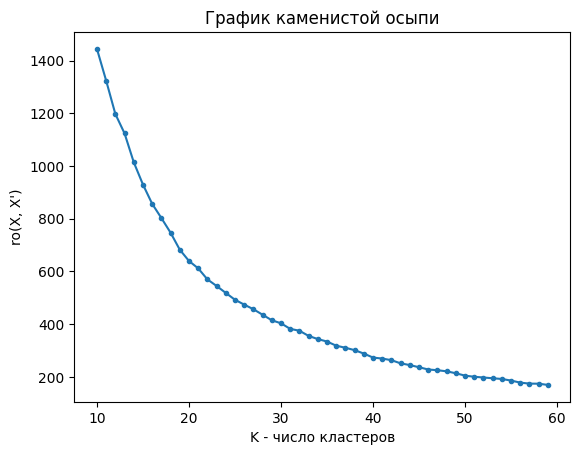

In [38]:
from sklearn.cluster import KMeans

# Рассмотрим число кластеров с запасом
K = range(10, 60)

# Для каждого k будет построено 10 моделей, выбирается в итоге лучшая (меньшая сумма внутрикластерных расстояний, значение inertia_).
# Начальная инициализация по умолчания производится методом k-means++
dist = [KMeans(n_clusters = k, random_state = 1, n_init = 10).fit(X).inertia_ for k in K]
rock_line = pd.DataFrame()
rock_line['K - число кластеров'] = K
rock_line["ro(X, X')"] = dist

plt.plot(rock_line['K - число кластеров'], rock_line["ro(X, X')"], marker='.')
plt.xlabel('K - число кластеров')
plt.ylabel("ro(X, X')")
plt.title('График каменистой осыпи')
plt.show()

Алгоритм k-means не выдаёт какого-кибо резкого изменения кривой.  
Визуально наиболее подхоящим кажется количество в 20 кластеров.  
По разобъём, для сравнения, на теже 25 кластеров как предыдущем алгоритме

In [39]:
#Добавим в данные графу "кластер" и посмотрим
model = KMeans(n_clusters = 25, random_state = 1, n_init=10)
model.fit(X)

KMeans(n_clusters=25, random_state=1)

In [40]:
silhouette_score(X, model.labels_)

0.5252861628921573

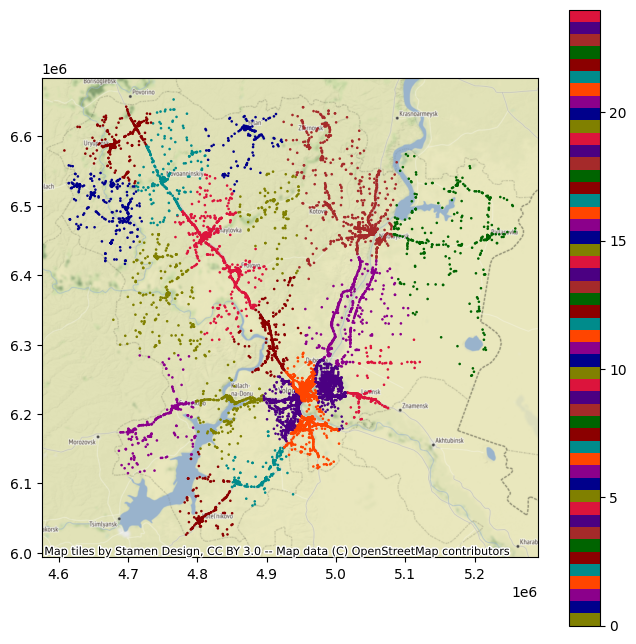

In [41]:
#Добавим в данные графу "кластер" и посмотрим
fig, ax = plt.subplots(figsize=(8, 8))
coord_clusters_wm = gpd.GeoDataFrame(geo_dtp_data_clipped['geometry'])
coord_clusters_wm = coord_clusters_wm.to_crs(epsg=3857)
coord_clusters_wm['Сluster'] = model.labels_
coord_clusters_wm.plot(ax=ax, marker='.', column='Сluster', legend=True, cmap=cmap, markersize=3)
cx.add_basemap(ax)

Получили, на мой взгляд, схожую картину.

### Алгоритм DBScan

In [42]:
from sklearn.cluster import DBSCAN
import numpy as np

In [43]:
# Чтобы выбрать и оценить диаметр поиска проанализируем имеющиеся данные.
# Длина в км от 1 ° широты (lat) = всегда 111,32 км
width_grad = (X.max() - X.min())['lat'] # Ширина диапазона в градусах
width_km = width_grad * 111.32 # ~ Ширина диапазона в км
num_steps = int(width_km / 1) # На сколько сегментов нужно разделить диапазон, чтобы получить диаметр 1 км
km_step = width_km / num_steps
km_step

1.0008283117848402

In [44]:
eps_array = np.arange(km_step / 5, km_step * 10 , km_step / 2 ) # 0.2 км ... 10 км с шагом 0,5 км.
eps_array /= 111.32 # перевести в градусы
len(eps_array), eps_array
min_samples_array = [10, 30, 50, 70, 100]

In [45]:
# Внимание Очень долго делает подбор параметров поэтому замментирую код.

# for eps in eps_array:
#     for min_samples in min_samples_array:
#         clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
#         cluster_labels = clusterer.labels_
#         if len(set(cluster_labels)) == 1:
#             continue
#         silhouette_avg = silhouette_score(X, cluster_labels)
#         print(
#             "For eps =",
#                 eps,
#             "For min_samples =",
#                 min_samples,
#             "Count clusters =",
#                 len(set(cluster_labels)),
#             "The average silhouette_score is :",
#                 silhouette_avg,
#         )

Лучший результат получился при  
For eps = 0.0872083599022004 For min_samples = 50 Count clusters = 21 The average silhouette_score is : 0.48364764291651735

In [46]:
clusterer = DBSCAN(eps=0.087208359, min_samples=50).fit(X)
print('Количество кластеров', len(set(clusterer.labels_)))
silhouette_score(X, clusterer.labels_)

Количество кластеров 21


0.48364764291651735

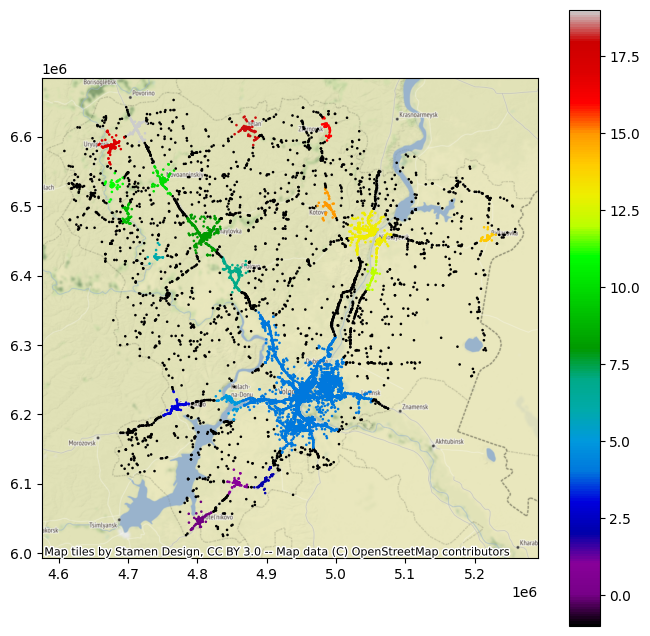

In [47]:
#Добавим в данные графу "кластер" и посмотрим
fig, ax = plt.subplots(figsize=(8, 8))
coord_clusters_wm = gpd.GeoDataFrame(geo_dtp_data_clipped['geometry'])
coord_clusters_wm = coord_clusters_wm.to_crs(epsg=3857)
coord_clusters_wm['Сluster'] = clusterer.labels_
coord_clusters_wm.plot(ax=ax, marker='.', column='Сluster', legend=True, cmap='nipy_spectral', markersize=3)
cx.add_basemap(ax)

Получилось довольно интересно.  
Выдеделились кластеры городов и крупные дорожные артерии прилегабщие к ним.  
Города Волгоград и Волжский попали в один большой кластер, что визуально так и вопринимается. Но зато выделились многие мелкие посёлки. При этом отдельные рассыпанные по территории ДТП попали в класс шумов.

### Вывод
Таким образом мы можем говорить о местах с наиболее концентрированными случаями аварий. И значит находясь на этих территориях наиболее вероятно вовасть в ДТП.

Думаю с этим можно работать дальше.

Посмотрим в какие кластеры попало больше всего аварий. за исключением шумов

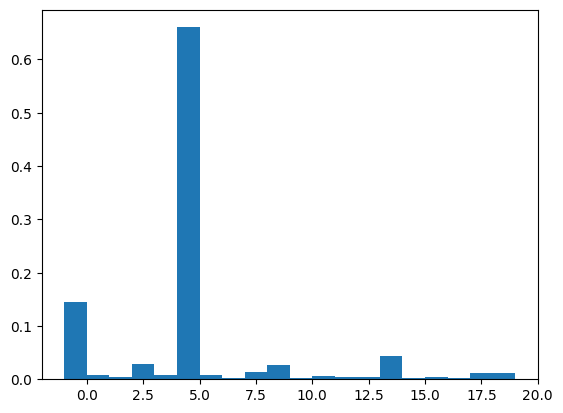

In [48]:
count, clust, _ = plt.hist(coord_clusters_wm['Сluster'], bins=len(set(coord_clusters_wm['Сluster']))-1, density=True)

In [49]:
def dict_sort(slovar) -> dict:
    'Сортировка словаря по значениям'
    sorted_tuples = sorted(slovar.items(), key=lambda item: item[1], reverse=True)
    return {k: v for k, v in sorted_tuples}

In [50]:
clusters_count = dict(zip(clust, count))
clusters_count.pop(-1.0) # Уберём класс шумов из выборки`
most_big_clusters = dict_sort(clusters_count)
most_big_clusters = {k: most_big_clusters[k] for k in list(most_big_clusters.keys())[:3]}
most_big_clusters

{4.0: 0.6604366347177849, 13.0: 0.04307774227902023, 2.0: 0.029446219382321618}

Мы получили три кластера с наиболее частыми ДТП. Визуализируем эти классы.

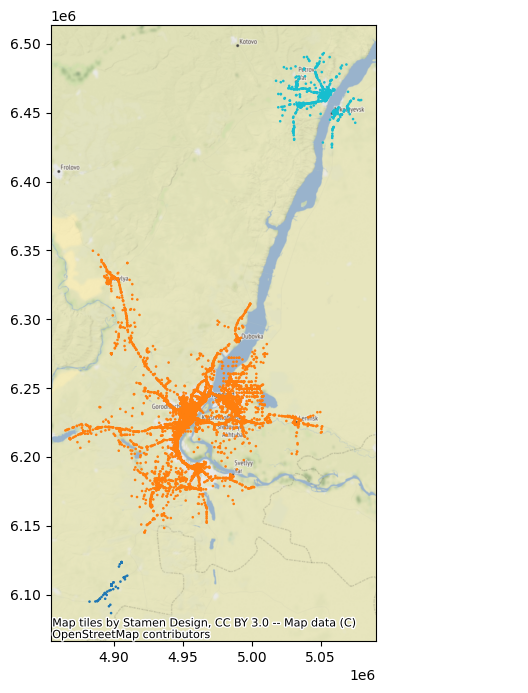

In [51]:
#Добавим в данные графу "кластер" и посмотрим
fig, ax = plt.subplots(figsize=(8, 8))
coord_clusters_wm[ coord_clusters_wm.Сluster.isin(most_big_clusters.keys()) ].plot(
    ax=ax, marker='.', column='Сluster', cmap='tab10', markersize=3)
cx.add_basemap(ax)

И это логично. Наибольшее количество ДТП происходят в больших городах. Тут было бы правильно смотреть значения относительно общего количества транспортных средств в кластере, но такими данными не располагаем.

Так же интересен кластер №2. Удивительно плотно расположены аварии. Там либо так записаны данные, либо очень аварийное место.

Здесь же, на более детальной карте, видно, что географические координаты не везде точны. Имеем множество выбросов, располагающихся на воде и имеющих не характерный для дорог рисунок. 

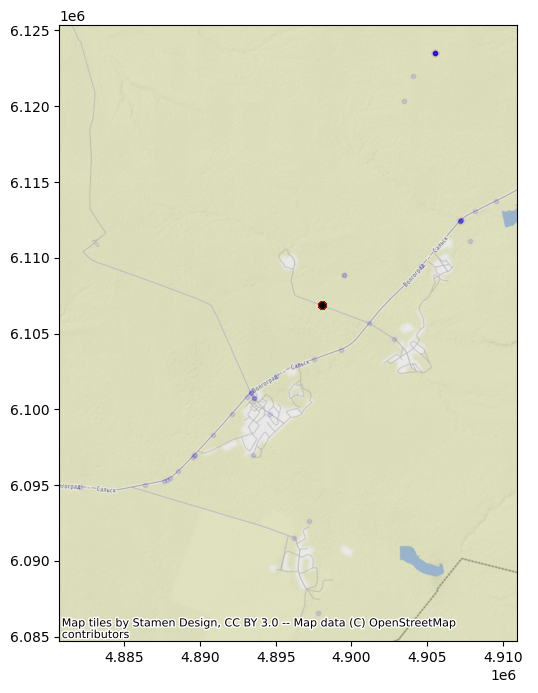

In [52]:
#Добавим в данные графу "кластер" и посмотрим
fig, ax = plt.subplots(figsize=(8, 8))
cluster2 = coord_clusters_wm[coord_clusters_wm.Сluster == 2.0]
cluster2.plot(ax=ax, marker='.', c='blue', alpha = 0.1)
cluster2.plot(ax=ax, marker='o', c='red', alpha = 0.005)
cx.add_basemap(ax)

На карте видим три точки, в которых сконцентрированны аварии. Одна из них сильно выделяется.  
Пробуем выделить эту точку и посмотреть подробнее что там происходит.

In [53]:
X_clust2 = X.copy()
X_clust2['Сluster'] = clusterer.labels_
X_clust2 = X_clust2[X_clust2['Сluster'] == 2.0]
X_clust2.pop('Сluster')

id
2462183    2
2465582    2
2587437    2
2549004    2
2456877    2
          ..
2459286    2
2459114    2
2459111    2
2469616    2
2459103    2
Name: Сluster, Length: 553, dtype: int64

In [54]:
clusterer = DBSCAN(eps=0.01, min_samples=5).fit(X_clust2)
print('Количество кластеров', len(set(clusterer.labels_)))
silhouette_score(X_clust2, clusterer.labels_)

Количество кластеров 5


0.9157055920153396

c:\Users\work\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


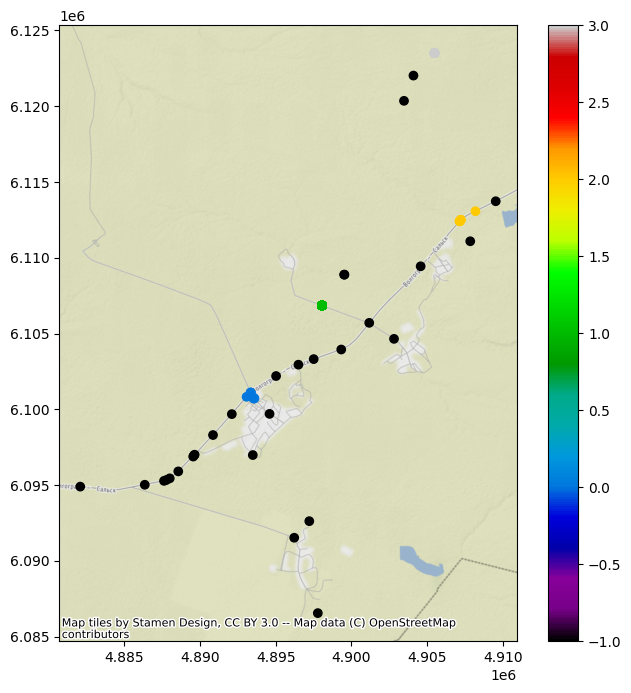

In [55]:
#Добавим в данные графу "кластер" и посмотрим
fig, ax = plt.subplots(figsize=(8, 8))
cluster2['Сluster'] = clusterer.labels_
cluster2.plot(ax=ax, marker='o', column='Сluster', legend=True, cmap='nipy_spectral')
cx.add_basemap(ax)

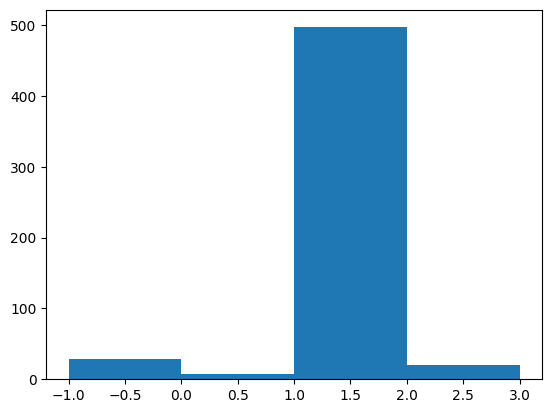

In [56]:
count, clust, _ = plt.hist(cluster2['Сluster'], bins=len(set(cluster2['Сluster']))-1)

Получилось выделить ещё три скопления аварий смотрим что творится в кластере 1

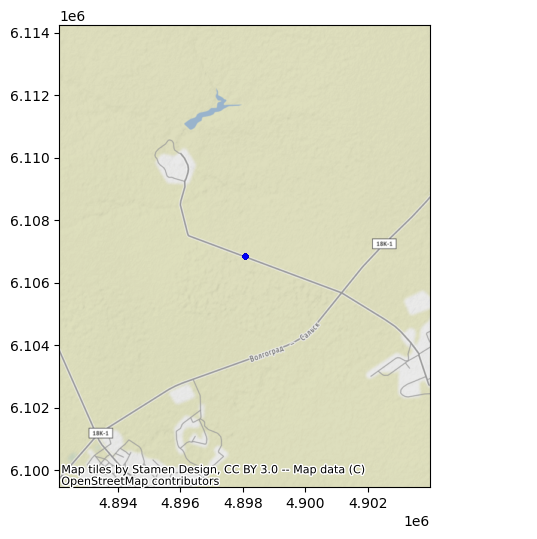

In [57]:
#Добавим в данные графу "кластер" и посмотрим
fig, ax = plt.subplots(figsize=(6, 6))
cluster1 = cluster2[cluster2.Сluster == 1.0]
cluster1.plot(ax=ax, marker='.', c='blue', alpha = 0.1)
xlim_mean = (ax.get_xlim()[1]-ax.get_xlim()[0])*0.489
ylim_mean = (ax.get_ylim()[1]-ax.get_ylim()[0])*0.489
ax.set_xlim(ax.get_xlim()[0]+xlim_mean, ax.get_xlim()[1]-xlim_mean)
ax.set_ylim(ax.get_ylim()[0]+ylim_mean, ax.get_ylim()[1]-ylim_mean)
cx.add_basemap(ax)

In [58]:
X_clust2['Cluster'] = clusterer.labels_
X_clust1 = X_clust2[X_clust2['Cluster'] == 1]
max_min = X_clust1.max() - X_clust1.min()
print(format(max_min['lat'], '.50f'))
print(format(max_min['long'], '.50f'))
X_clust1.shape

0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000


(497, 3)

497 точек полностью совпадают. Посмотрим по индексу какие там содержатся данные

In [59]:
geo_dtp_data_clipped.loc[X_clust1.index].describe(include=[object], datetime_is_numeric=True)


light                        point     region scheme  \
count                   497                          497        497    480   
unique                    5                            1          4     49   
top     Светлое время суток  {'lat': 48.0, 'long': 44.0}  Волгоград    820   
freq                    267                          497        481     80   

                               address      category severity vehicles  \
count                              491           497      497      497   
unique                             414             9        3      473   
top     г Волгоград, ул им Шурухина, 0  Столкновение   Легкий      [ ]   
freq                                 9           231      231       25   

       participants          parent_region  
count           497                    497  
unique           60                      1  
top             [ ]  Волгоградская область  
freq            304                    497

### Вывод.  
В эти строки не верно вписаны координаты. На самом деле данные указывают на то, что ДТП произошло в Волгограде, а не в области.
Уже в трёх местах было отсечено, что координаты не соответвуют реальности. Поэтому опираться на эти данные не стоит.

## Анализ тяжести ДТП от погодных условий

Для этого выберем данные для анализа:

Предикторы:
```
    "light": "Светлое время суток",                 # время суток
    "weather": ["Ясно"],                            # погода
    "datetime": "2017-08-05 13:06:00",              # дата и время
    "road_conditions": ["Сухое"],                   # состояние дорожного покрытия
```
Отклик:
```
    "severity": "Легкий",                           # тяжесть ДТП/вред здоровью
```

In [60]:
# geo_dtp_weather = geo_dtp_data_clipped[['light', 'weather', 'datetime', 'severity', 'road_conditions']].copy()
# geo_dtp_weather.head()

In [61]:
geo_dtp_data_clipped.columns

Index(['light', 'point', 'region', 'scheme', 'address', 'category', 'datetime',
       'severity', 'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'participants_count', 'geometry'],
      dtype='object')

К этому моменту я обнаружил, что модуль geopandas загрузил не все данные из файла ```volgogradskaia-oblast.geojson```  
Например отсутсвуют нужные поля из описания ```['weather', 'road_conditions'] not in index```
Открыв файл в текстовом редакторе я выяснил, что эти поля имеют списочный тип данных. Будем пробовать подгрузить их другим способом.

### Загрузка данных

In [62]:
import json

In [63]:
# Загрузим данные из файла
with open("volgogradskaia-oblast.geojson", "r", encoding="utf8") as read_file:
    data = json.load(read_file)

In [64]:
# Изучим их структуру
data.keys()

dict_keys(['type', 'features'])

In [65]:
len(data['features']), type(data['features'])

(19546, list)

In [66]:
data['features'][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [67]:
# Имеем следующую вложенность
# Словарь (брать только features), список всех записей (0..19546), словарь (брать только properties)
# data['features'][1..n]['properties']
# Уберём лишнюю вложенность и сформируем новый 
data_preobr = [features['properties'] for features in data['features']]

In [68]:
len(data_preobr)

19546

In [69]:
df = pd.DataFrame(data_preobr)
df = df.set_index(['id'])

In [70]:
df.shape

(19546, 19)

In [71]:
# Имеем вложенность данных, которую надо развернуть в простую таблицу для удобства работы
df.head(3)

tags  \
id                                                           
2655081                [Дорожно-транспортные происшествия]   
2655084                [Дорожно-транспортные происшествия]   
2464197  [Дорожно-транспортные происшествия, ДТП и пост...   

                                               light  \
id                                                     
2655081                          Светлое время суток   
2655084  В темное время суток, освещение отсутствует   
2464197                          Светлое время суток   

                                         point  \
id                                               
2655081  {'lat': 48.058305, 'long': 42.376692}   
2655084  {'lat': 48.391983, 'long': 42.322276}   
2464197  {'lat': 48.291002, 'long': 42.277859}   

                                                    nearby         region  \
id                                                                          
2655081  [Нерегулируемый перекрёсток неравнозначных ули...  Чернышковский   
2655084                                                 []  Чернышковский   
2464197  [Выезд с прилегающей территории, Нерегулируемы...  Чернышковский   

        scheme                                            address     weather  \
id                                                                              
2655081    500  А/д Цимлянск - Нижнегнутов - Чернышковский (в ...  [Пасмурно]   
2655084    610                                               None     [Дождь]   
2464197    500                                               None  [Пасмурно]   

               category             datetime severity  \
id                                                      
2655081    Столкновение  2021-11-19 11:35:00  Тяжёлый   
2655084  Съезд с дороги  2021-11-03 02:30:00  Тяжёлый   
2464197    Столкновение  2016-06-06 14:50:00  Тяжёлый   

                                                  vehicles  dead_count  \
id                                                                       
2655081  [{'year': 2020, 'brand': 'ВАЗ', 'color': 'Черн...           0   
2655084  [{'year': 2002, 'brand': 'ВАЗ', 'color': 'Серы...           0   
2464197  [{'year': 1997, 'brand': 'VOLVO', 'color': 'Кр...           0   

        participants  injured_count          parent_region  \
id                                                           
2655081           []              2  Волгоградская область   
2655084           []              2  Волгоградская область   
2464197           []              2  Волгоградская область   

                                           road_conditions  \
id                                                           
2655081                                            [Сухое]   
2655084  [Мокрое, Отсутствие, плохая различимость гориз...   
2464197  [Сухое, Отсутствие, плохая различимость горизо...   

         participants_count               participant_categories  
id                                                                
2655081                   2                      [Все участники]  
2655084                   2                      [Все участники]  
2464197                   3  [Мотоциклисты, Дети, Все участники]

In [72]:
# Отформатируем столбец времени
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'].head(3)

id
2655081   2021-11-19 11:35:00
2655084   2021-11-03 02:30:00
2464197   2016-06-06 14:50:00
Name: datetime, dtype: datetime64[ns]

In [73]:
# Имеем пропущенные столбцы
set(df.columns) - set(geo_dtp_data_clipped.columns)

{'nearby', 'participant_categories', 'road_conditions', 'tags', 'weather'}

### Объединение данных
Итак у нас имеется два дата фрейма, которые нужно объединить. Они имеют разное количество столбцов и разное количество строк. Помним, что мы удаляли территориалые выбросы. Это нужно учесть при объединении. Так же имеем разный тип дата фреймов pandas и geopandas.

In [74]:
geo_dtp_data_clipped.shape

(18780, 15)

In [75]:
geo_dtp_full_data_clipped = geo_dtp_data_clipped.merge(df[['nearby', 'participant_categories', 'road_conditions', 'tags', 'weather']], left_index=True, right_index=True)
print(geo_dtp_full_data_clipped.shape)
geo_dtp_full_data_clipped.head(2)

(18780, 20)


light  \
id                                                     
2733815  В темное время суток, освещение отсутствует   
2566738  В темное время суток, освещение отсутствует   

                                         point           region scheme  \
id                                                                       
2733815   {'lat': 47.51123, 'long': 42.973022}  Котельниковский    840   
2566738  {'lat': 47.628206, 'long': 43.228884}  Котельниковский    600   

                                                   address           category  \
id                                                                              
2733815  Автомобильная дорога Волгоград - Октябрьский -...  Наезд на пешехода   
2566738                                               None     Съезд с дороги   

                   datetime     severity  \
id                                         
2733815 2022-07-04 22:15:00  С погибшими   
2566738 2021-04-19 18:30:00      Тяжёлый   

                                                  vehicles  dead_count  \
id                                                                       
2733815  [ { "year": null, "brand": null, "color": "Чер...           1   
2566738  [ { "year": 2010, "brand": "ВАЗ", "color": "Си...           0   

                                              participants  injured_count  \
id                                                                          
2733815  [ { "role": "Пешеход", "gender": "Мужской", "v...              0   
2566738                                                [ ]              1   

                 parent_region  participants_count                   geometry  \
id                                                                              
2733815  Волгоградская область                   2  POINT (42.97302 47.51123)   
2566738  Волгоградская область                   2  POINT (43.22888 47.62821)   

        nearby     participant_categories road_conditions  \
id                                                          
2733815     []  [Пешеходы, Все участники]         [Сухое]   
2566738     []            [Все участники]        [Мокрое]   

                                        tags     weather  
id                                                        
2733815  [Дорожно-транспортные происшествия]      [Ясно]  
2566738  [Дорожно-транспортные происшествия]  [Пасмурно]

Отлично! Имеем все данные и двигаемся дальше.

### Преобразование данных

In [76]:
# выделяем нужные данные
geo_dtp_weather = geo_dtp_full_data_clipped[['light', 'weather', 'datetime', 'severity', 'road_conditions', 'geometry']].copy()
geo_dtp_weather.head(2)

light     weather  \
id                                                                 
2733815  В темное время суток, освещение отсутствует      [Ясно]   
2566738  В темное время суток, освещение отсутствует  [Пасмурно]   

                   datetime     severity road_conditions  \
id                                                         
2733815 2022-07-04 22:15:00  С погибшими         [Сухое]   
2566738 2021-04-19 18:30:00      Тяжёлый        [Мокрое]   

                          geometry  
id                                  
2733815  POINT (42.97302 47.51123)  
2566738  POINT (43.22888 47.62821)

Столбцы ```light, weather, road_conditions``` имеют категориальные признаки. Причём ```weather, road_conditions``` имеют тип списка.  
Проанализируем эти столбцы и отранжируем.

In [77]:
# Получим список всех возможных значений
def from_df_read_unique_list_values_to_dict (df, column):
    '''На вход подаём датафрейм и строку с названием столбца
    На выходе получаем словарь с
    ключём - значение списка
    значение - количество появлений в столбце
    '''
    n = {} # index = длина списка, key = количество таких списков в данных
    for i in range(len(df)):
        for val in df[column].iloc[i]:
            n[val] = n.setdefault(val,0) + 1
    n_sorted = dict_sort(n)
    print('Всего',len(n_sorted),'значений.')
    # print(n_sorted)
    return n_sorted

In [78]:
from_df_read_unique_list_values_to_dict(geo_dtp_weather, 'weather')

Всего 9 значений.


{'Ясно': 13738,
 'Пасмурно': 3902,
 'Дождь': 745,
 'Снегопад': 343,
 'Туман': 148,
 'Температура выше +30С': 59,
 'Метель': 25,
 'Ураганный ветер': 6,
 'Температура ниже -30С': 1}

Из вывода становится понятно, что данные можно разделить на столбцы и ранжировать

**Облачность**: 'Ясно', 'Пасмурно', 'Туман'  
**Осадки**: 'Дождь', 'Снегопад'  
**Ветер**: 'Метель', 'Ураганный ветер'  
**Температура**: 'Температура выше +30С', 'Температура ниже -30С'

По сути данные избыточны. И можем назначить следующим образом:  
Если Снегопад, то отрицательная температура и осадки  
Если доджь, то положительная температура и осадки  
Если Метель, то отрицательная температура и ветер  
Если туман, то температура около нуля

**Облачность**: Ясно, Пасмурно, Туман  
**Осадки**: Нет, Да  
**Ветер**: Нет, Да, Ураган  
**Температура**: t<-30, -30<=t<0, 0, 0<t<=+30, >+30

Ранжируем по бальной системе  
**Облачность**: 0, 1, 2  
**Осадки**: 0, 1  
**Ветер**: 0, 1, 2  
**Температура**: -2, -1, 0, 1, 2  

In [79]:
# Добавим столбцы погоды
geo_dtp_weather = geo_dtp_weather.assign(cloudly=0, rainfall=0, windy=0, temp=None)
geo_dtp_weather.head(1)

light weather  \
id                                                             
2733815  В темное время суток, освещение отсутствует  [Ясно]   

                   datetime     severity road_conditions  \
id                                                         
2733815 2022-07-04 22:15:00  С погибшими         [Сухое]   

                          geometry  cloudly  rainfall  windy  temp  
id                                                                  
2733815  POINT (42.97302 47.51123)        0         0      0  None

In [80]:
# запоним новые столцы данными на основании столбца weather
# Словарь для заполнения
slovar = {
    'Ясно':           {'cloudly':0},
    'Пасмурно':       {'cloudly':1},
    'Туман':          {'cloudly':2,  'temp': 0},
    'Снегопад':       {'rainfall':1, 'temp':-1},
    'Дождь':          {'rainfall':1, 'temp':1},
    'Метель':         {'windy':1, 'temp':-1},
    'Ураганный ветер':{'windy':2},
    'Температура ниже -30С':{'temp':-2},
    'Температура выше +30С':{'temp':2},
    }

In [81]:
# Функция для заполнения
def replace_list_values_in_df_by_values_from_dict(df, column, slovar):
    '''На вход подаём датафрейм, строку с названием столбца и словарь для замены
    На выходе получаем копию датафрейма с заполненными данными
    '''
    new_df = df.copy()
    for i in new_df.index:                # пробегаемся по всему датасету
        ls = new_df[column].loc[i]
        for str_val in ls:                      # Пробегаемся по списку значений в ячейке данных
            if str_val in slovar.keys():           # Если есть в списке значения из словаря
                for key, val in slovar[str_val].items():    # То пробешаемся по словарю и вставляем значения в датафрейм
                    new_df.loc[i, key] = val
    new_df.pop(column)           # Удалим разбираемый столбец
    return new_df

In [82]:
geo_dtp_weather = replace_list_values_in_df_by_values_from_dict (geo_dtp_weather, 'weather', slovar)
geo_dtp_weather.head()

light            datetime  \
id                                                                         
2733815  В темное время суток, освещение отсутствует 2022-07-04 22:15:00   
2566738  В темное время суток, освещение отсутствует 2021-04-19 18:30:00   
2600047                                      Сумерки 2021-07-24 04:25:00   
2459739                                      Сумерки 2018-03-26 06:00:00   
2468014                          Светлое время суток 2015-10-11 18:00:00   

            severity                                    road_conditions  \
id                                                                        
2733815  С погибшими                                            [Сухое]   
2566738      Тяжёлый                                           [Мокрое]   
2600047  С погибшими                                            [Сухое]   
2459739      Тяжёлый                                            [Сухое]   
2468014      Тяжёлый  [Сухое, Отсутствие, плохая различимость горизо...   

                          geometry  cloudly  rainfall  windy  temp  
id                                                                  
2733815  POINT (42.97302 47.51123)        0         0      0  None  
2566738  POINT (43.22888 47.62821)        1         0      0  None  
2600047  POINT (43.18845 47.62877)        1         0      0  None  
2459739  POINT (43.18230 47.62883)        1         0      0  None  
2468014  POINT (43.18139 47.62889)        0         0      0  None

### Посмотрим какие значения принимает severity


In [83]:
geo_dtp_weather.groupby('severity').count()

light  datetime  road_conditions  geometry  cloudly  rainfall  \
severity                                                                     
Легкий        9071      9071             9071      9071     9071      9071   
С погибшими   1857      1857             1857      1857     1857      1857   
Тяжёлый       7852      7852             7852      7852     7852      7852   

             windy  temp  
severity                  
Легкий        9071   539  
С погибшими   1857   164  
Тяжёлый       7852   602

In [84]:
# Столбец меняем прямо на месте 
slovar = {
    'Легкий': 1,
    'Тяжёлый': 2,
    'С погибшими':  3,
}
for key, val in slovar.items():
    geo_dtp_weather.loc[geo_dtp_weather['severity'] == key, 'severity'] = val
geo_dtp_weather.head()

light            datetime  \
id                                                                         
2733815  В темное время суток, освещение отсутствует 2022-07-04 22:15:00   
2566738  В темное время суток, освещение отсутствует 2021-04-19 18:30:00   
2600047                                      Сумерки 2021-07-24 04:25:00   
2459739                                      Сумерки 2018-03-26 06:00:00   
2468014                          Светлое время суток 2015-10-11 18:00:00   

        severity                                    road_conditions  \
id                                                                    
2733815        3                                            [Сухое]   
2566738        2                                           [Мокрое]   
2600047        3                                            [Сухое]   
2459739        2                                            [Сухое]   
2468014        2  [Сухое, Отсутствие, плохая различимость горизо...   

                          geometry  cloudly  rainfall  windy  temp  
id                                                                  
2733815  POINT (42.97302 47.51123)        0         0      0  None  
2566738  POINT (43.22888 47.62821)        1         0      0  None  
2600047  POINT (43.18845 47.62877)        1         0      0  None  
2459739  POINT (43.18230 47.62883)        1         0      0  None  
2468014  POINT (43.18139 47.62889)        0         0      0  None

### Посмотрим какие значения принимает light

In [85]:
geo_dtp_weather.groupby('light').count()

datetime  severity  \
light                                                             
В темное время суток, освещение включено         4037      4037   
В темное время суток, освещение не включено       239       239   
В темное время суток, освещение отсутствует      2158      2158   
Светлое время суток                             11811     11811   
Сумерки                                           535       535   

                                             road_conditions  geometry  \
light                                                                    
В темное время суток, освещение включено                4037      4037   
В темное время суток, освещение не включено              239       239   
В темное время суток, освещение отсутствует             2158      2158   
Светлое время суток                                    11811     11811   
Сумерки                                                  535       535   

                                             cloudly  rainfall  windy  temp  
light                                                                        
В темное время суток, освещение включено        4037      4037   4037   392  
В темное время суток, освещение не включено      239       239    239    23  
В темное время суток, освещение отсутствует     2158      2158   2158   238  
Светлое время суток                            11811     11811  11811   613  
Сумерки                                          535       535    535    39

In [86]:
# Выстроим порядок по осчещённости
slovar = {
    'Светлое время суток': 3,
    'Сумерки': 2,
    'В темное время суток, освещение включено':  1,
    'В темное время суток, освещение не включено': 0,
    'В темное время суток, освещение отсутствует': 0,
}
for key, val in slovar.items():
    geo_dtp_weather.loc[geo_dtp_weather['light'] == key, 'light'] = val
geo_dtp_weather.head()

light            datetime severity  \
id                                           
2733815     0 2022-07-04 22:15:00        3   
2566738     0 2021-04-19 18:30:00        2   
2600047     2 2021-07-24 04:25:00        3   
2459739     2 2018-03-26 06:00:00        2   
2468014     3 2015-10-11 18:00:00        2   

                                           road_conditions  \
id                                                           
2733815                                            [Сухое]   
2566738                                           [Мокрое]   
2600047                                            [Сухое]   
2459739                                            [Сухое]   
2468014  [Сухое, Отсутствие, плохая различимость горизо...   

                          geometry  cloudly  rainfall  windy  temp  
id                                                                  
2733815  POINT (42.97302 47.51123)        0         0      0  None  
2566738  POINT (43.22888 47.62821)        1         0      0  None  
2600047  POINT (43.18845 47.62877)        1         0      0  None  
2459739  POINT (43.18230 47.62883)        1         0      0  None  
2468014  POINT (43.18139 47.62889)        0         0      0  None

### Осталось road_conditions


In [87]:
from_df_read_unique_list_values_to_dict(geo_dtp_weather, 'road_conditions')

Всего 40 значений.


{'Сухое': 14357,
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части': 6397,
 'Мокрое': 3200,
 'Отсутствие дорожных знаков в необходимых местах': 2036,
 'Отсутствие пешеходных ограждений в необходимых местах': 1235,
 'Неправильное применение, плохая видимость дорожных знаков': 841,
 'Дефекты покрытия': 716,
 'Недостатки зимнего содержания': 647,
 'Заснеженное': 453,
 'Нарушения в размещении наружной рекламы': 446,
 'Неудовлетворительное состояние обочин': 438,
 'Обработанное противогололедными материалами': 406,
 'Отсутствие освещения': 376,
 'Неровное покрытие': 149,
 'Иные недостатки': 139,
 'Отсутствие тротуаров (пешеходных дорожек)': 123,
 'Гололедица': 122,
 'Со снежным накатом': 120,
 'Отсутствие, плохая различимость вертикальной разметки': 106,
 'Загрязненное': 101,
 'Низкие сцепные качества покрытия': 79,
 'Отсутствие дорожных ограждений в необходимых местах': 73,
 'Недостаточное освещение': 46,
 'Неудовлетворительное состояние разделительной полосы': 39,
 

In [88]:
# Новые столбцы и значение по умолчанию
geo_dtp_weather = geo_dtp_weather.assign(
    road_grip=2,            # сцепление 0..2
    road_mark=2,            # дорожная разметка 0..2
    road_signs=2,           # Дорожные значки 0..2
    road_obstacles=0,       # Дорожные препятствия 0..2
    road_coating=2,         # Дорожное покрытие 0..2
    road_construction=2,    # Обустройство дороги 0..2
    road_distraction=0,     # отвлечение внимания 0..1
    road_traffic_lights=2,  # Светофор 0..2
    road_other_defects=0,   # Другие недостатки дороги 0..1
    )
geo_dtp_weather.head(1)

light            datetime severity road_conditions  \
id                                                           
2733815     0 2022-07-04 22:15:00        3         [Сухое]   

                          geometry  cloudly  rainfall  windy  temp  road_grip  \
id                                                                              
2733815  POINT (42.97302 47.51123)        0         0      0  None          2   

         road_mark  road_signs  road_obstacles  road_coating  \
id                                                             
2733815          2           2               0             2   

         road_construction  road_distraction  road_traffic_lights  \
id                                                                  
2733815                  2                 0                    2   

         road_other_defects  
id                           
2733815                   0

In [89]:
slovar = {
# По некоторым признакам состояния дороги можно судить о погоде:
# Для оточнения модели нужно проверить не расходятся ли эти данные с уже имеющимися о погоде
# В рамках данного исследование данное сравнение проводить не будем
 'Сухое': {'rainfall': 0}, # 14357,
 'Мокрое': {'rainfall': 1}, # 3200,
 'Недостатки зимнего содержания': {'temp':-1}, # 647,
 'Заснеженное': {'road_grip': 0, 'temp':-1}, # 453,
 'Обработанное противогололедными материалами': {'road_grip': 1, 'temp':-1}, # 406,
 'Гололедица': {'road_grip': 0, 'temp':-1}, # 122,
 'Со снежным накатом': {'road_grip': 0, 'temp':-1}, # 120,
 'Залитое (покрытое) водой': {'rainfall': 1}, # 7, хоть и не говорит о дожде, но редко встречается и мокрая дорога

 'Низкие сцепные качества покрытия': {'road_grip': 1}, # 79,

# Следующие значения стоит сравнить со столбецом освещения
# Так же отложим до лучших времён
 'Отсутствие освещения': {'light': 0}, # 376,
 'Недостаточное освещение': {'light': 1}, # 46,
 'Неисправное освещение': {'light': 1}, # 37,
# Сравнить с туманом
 'Ограничение видимости': {'cloudly': 2}, # 15,

# Разметка
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части': {'road_mark': 1}, # 6397,
 'Отсутствие, плохая различимость вертикальной разметки': {'road_mark': 1}, # 106,
 'Неудовлетворительное состояние разделительной полосы': {'road_mark': 0}, # 39,

# Дорожные знаки
 'Отсутствие дорожных знаков в необходимых местах': {'road_signs': 0}, # 2036,
 'Неправильное применение, плохая видимость дорожных знаков': {'road_signs': 1}, # 841,

# Дефекты покрытия
 'Дефекты покрытия': {'road_coating': 1}, # 716,
 'Неудовлетворительное состояние обочин': {'road_coating': 0}, # 438,
 'Неровное покрытие': {'road_coating': 1}, # 149,

# Препятствия
 'Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям': {'road_obstacles': 1}, # 17,
 'Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств': {'road_obstacles': 2}, # 15,
 'Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см': {'road_obstacles': 1}, # 8,

# Обустройство дороги
 'Отсутствие пешеходных ограждений в необходимых местах': {'road_construction': 1}, # 1235,
 'Отсутствие тротуаров (пешеходных дорожек)': {'road_construction': 1}, # 123,
 'Отсутствие дорожных ограждений в необходимых местах': {'road_construction': 1}, # 73,
 'Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта': {'road_construction': 1}, # 36,
 'Несоответствие дорожных ограждений предъявляемым требованиям': {'road_construction': 1}, # 6,
 'Отсутствие направляющих устройств и световозвращающих элементов на них': {'road_construction': 1}, # 5,

# Отвлечение внимания
 'Нарушения в размещении наружной рекламы': {'road_distraction': 1}, # 446,

# Светофор
 'Неисправность светофора': {'road_traffic_lights': 0}, # 33,
 'Плохая видимость светофора': {'road_traffic_lights': 1}, # 15,

# Иные недостатки не отнесённые ни в какую категорию. Так как редко встречаются все будут отнесеный в один столбец.
 'Иные недостатки': {'road_other_defects': 1}, # 139,
 'Загрязненное': {'road_other_defects': 1}, # 101,
 'Отсутствие временных ТСОД в местах проведения работ': {'road_other_defects': 1}, # 10,
 'Пыльное': {'road_other_defects': 1}, # 8,
 'Свежеуложенная поверхностная обработка': {'road_other_defects': 1}, # 6,
 'Плохая видимость световозвращателей, размещенных на дорожных ограждениях': {'road_other_defects': 1}, # 2,
 'Несоответствие железнодорожного переезда предъявляемым требованиям': {'road_other_defects': 1}, # 1

}

In [90]:
geo_dtp_weather = replace_list_values_in_df_by_values_from_dict (geo_dtp_weather, 'road_conditions', slovar)
geo_dtp_weather.head()

light            datetime severity                   geometry  \
id                                                                      
2733815     0 2022-07-04 22:15:00        3  POINT (42.97302 47.51123)   
2566738     0 2021-04-19 18:30:00        2  POINT (43.22888 47.62821)   
2600047     2 2021-07-24 04:25:00        3  POINT (43.18845 47.62877)   
2459739     2 2018-03-26 06:00:00        2  POINT (43.18230 47.62883)   
2468014     3 2015-10-11 18:00:00        2  POINT (43.18139 47.62889)   

         cloudly  rainfall  windy  temp  road_grip  road_mark  road_signs  \
id                                                                          
2733815        0         0      0  None          2          2           2   
2566738        1         1      0  None          2          2           2   
2600047        1         0      0  None          2          2           2   
2459739        1         0      0  None          2          2           2   
2468014        0         0      0  None          2          1           2   

         road_obstacles  road_coating  road_construction  road_distraction  \
id                                                                           
2733815               0             2                  2                 0   
2566738               0             2                  2                 0   
2600047               0             2                  2                 0   
2459739               0             2                  2                 0   
2468014               0             2                  2                 0   

         road_traffic_lights  road_other_defects  
id                                                
2733815                    2                   0  
2566738                    2                   0  
2600047                    2                   0  
2459739                    2                   0  
2468014                    2                   0

Столбец с температурой имеет множество не известных значений, которые мы можем восстановить из другого источника. Например с сайта https://rp5.ru/Архив_погоды_в_Волгограде_(аэропорт),_METAR . Здесь ссылка на архив метео наблюдейний только с одной метеостагнции Волгоградской области. Данные можно сказачать в формате csv. За раз возмоджно скачать информацию за годовой период. Нам нужно 7 периодов с 14 метеостанций. 
![Метео станции Волгоградской области](src/Метеостанции.png)

Процесс назначения температуры можно производить с помощью построения математической модели классификации метоположения метеостанции. Каждая станция есть центр класса. Их координаты известны. Все события ДТП можно относить к одной из метеовышек по наименьшему расстоянию до неё. Ещё более точно можно попробовать интерполировать значения температуры от вышки к вышке.
Это довольно друдоёмкая задача, поэтому в рамках данного исследования сбор дополнительных данных производиться не будет.

In [91]:
geo_dtp_weather.describe()

cloudly      rainfall         windy     road_grip     road_mark  \
count  18780.000000  18780.000000  18780.000000  18780.000000  18780.000000   
mean       0.223536      0.186901      0.001970      1.903035      1.651065   
std        0.436841      0.389842      0.051043      0.401448      0.480540   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      2.000000      1.000000   
50%        0.000000      0.000000      0.000000      2.000000      2.000000   
75%        0.000000      0.000000      0.000000      2.000000      2.000000   
max        2.000000      1.000000      2.000000      2.000000      2.000000   

         road_signs  road_obstacles  road_coating  road_construction  \
count  18780.000000    18780.000000  18780.000000       18780.000000   
mean       1.768104        0.002929      1.913206           1.922790   
std        0.604362        0.067214      0.353188           0.266931   
min        0.000000        0.000000      0.000000           1.000000   
25%        2.000000        0.000000      2.000000           2.000000   
50%        2.000000        0.000000      2.000000           2.000000   
75%        2.000000        0.000000      2.000000           2.000000   
max        2.000000        2.000000      2.000000           2.000000   

       road_distraction  road_traffic_lights  road_other_defects  
count      18780.000000         18780.000000        18780.000000  
mean           0.023749             1.995687            0.014004  
std            0.152269             0.088370            0.117511  
min            0.000000             0.000000            0.000000  
25%            0.000000             2.000000            0.000000  
50%            0.000000             2.000000            0.000000  
75%            0.000000             2.000000            0.000000  
max            1.000000             2.000000            1.000000

## Пора строить математичесую модель предсказания

Для целей предсказания ДТП по погоде:
1. Подготовым данные предикторы и отклики
2. Разделим выборку на обучающие и тестовые

In [92]:
X = geo_dtp_weather.sort_values('datetime')[['cloudly', 'rainfall', 'windy', 'light']]
X.head(3)

cloudly  rainfall  windy light
id                                     
2463903        0         0      0     0
2463801        1         0      0     1
2463902        1         0      0     3

In [93]:
y = geo_dtp_weather.sort_values('datetime')['severity'].astype('int32')
y.head(3)

id
2463903    2
2463801    2
2463902    2
Name: severity, dtype: int32

Посмотрим распределение откликов
Помним, что предварительно назначили следующие численные обозначения классов.
```
    1: 'Легкий'
    2: 'Тяжёлый'
    3: 'С погибшими'
```

(array([9071., 7852., 1857.]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <BarContainer object of 3 artists>)

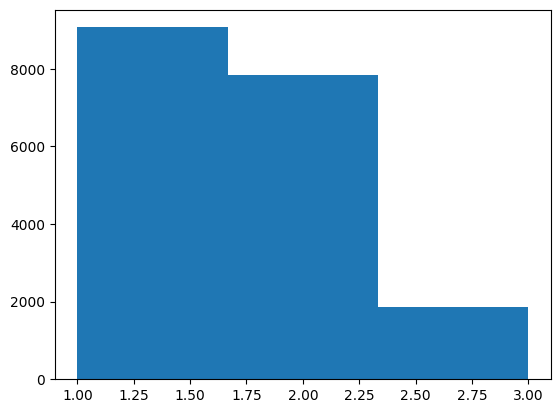

In [94]:
plt.hist(y,bins = len(set(y)))

Видим, что вероятность появления третьего класса аварий (с погибшими) сильно отличается от первых двух, что может создать сложность в предсказании.

Так как данные у нас имеют метку времени, то разобъём их на прошлые - тренировочные и будущие - тестовые 

In [95]:
X_train = X.head(int(len(X)*0.8))
X_test = X.tail(int(len(X)*0.2))
X_train.shape[0], X_test.shape[0]

(15024, 3756)

In [96]:
y_train = y.head(int(len(y)*0.8))
y_test = y.tail(int(len(y)*0.2))
y_train.shape[0], y_test.shape[0]

(15024, 3756)

#### Обучение модели логистической регрессии

In [97]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [98]:
reg = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(X_train, y_train.to_list())

Предсказание результатов с помощью обученной модели

In [99]:
y_predicted = reg.predict(X_test)
y_predicted = pd.Series(y_predicted, index=X_test.index)
y_predicted.head()

id
2557645    2
2557644    1
2557694    1
2557697    1
2557693    2
dtype: int32

Подсчёт метрик

In [100]:
metrics.accuracy_score(y_test, y_predicted)

0.5351437699680511

(array([1.34877529, 0.65122471]),
 array([1. , 1.5, 2. ]),
 <BarContainer object of 2 artists>)

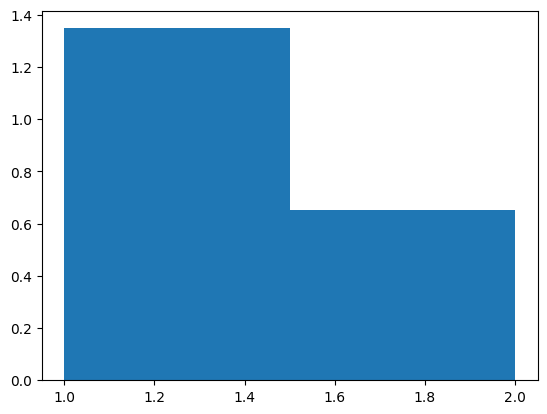

In [101]:
plt.hist(y_predicted,bins = len(set(y_predicted)), density=True)

(array([0.82468051, 0.53674121, 0.13857827]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <BarContainer object of 3 artists>)

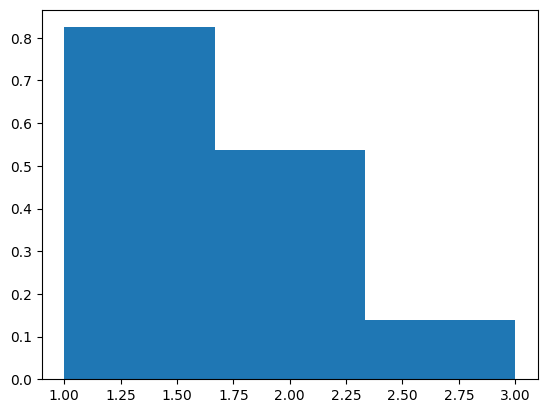

In [102]:
plt.hist(y_test,bins = len(set(y_test)), density=True)

#### Вывод
Логистическая регрессия показала точность предсказания чуть более вероятного (для трёх классов 0.33). Но всё же это далеко от желаемого результата. Более того модель не предсказала ни одного события класса 3 - с погибшими. такая модель не годится. Пробуем другую.

### Преобразуем данные

Пробуем преобразовать данные возведением в степень, таким образо стараемся выделить нелинейные зависимости.

In [103]:
from sklearn.decomposition import PCA

In [104]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
X_train_pca

(15024, 3)


array([[ 2.10123287, -0.4611428 ,  0.0283541 ],
       [ 1.16435089,  0.42769495,  0.60473489],
       [-0.82983318,  0.57996062,  0.598386  ],
       ...,
       [ 1.10414084, -0.38500996,  0.02517965],
       [-0.89004323, -0.23274429,  0.01883076],
       [-0.82983318,  0.57996062,  0.598386  ]])

In [105]:
# Нормируем полученные данные
X_train_pca = (X_train_pca - X_train_pca.min()) / (X_train_pca.max() - X_train_pca.min())
X_train_pca

array([[0.9470871 , 0.13579691, 0.29077966],
       [0.65045489, 0.41721753, 0.47327128],
       [0.01906349, 0.46542734, 0.47126112],
       ...,
       [0.6313914 , 0.15990182, 0.28977458],
       [0.        , 0.20811163, 0.28776442],
       [0.01906349, 0.46542734, 0.47126112]])

In [106]:
reg = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(X_train_pca, y_train.to_list())

In [107]:
y_predicted = reg.predict(X_test_pca)
y_predicted

array([1, 1, 1, ..., 1, 2, 2])

In [108]:
metrics.accuracy_score(y_test, y_predicted)

0.536741214057508

In [110]:
metrics.r2_score(y_test, y_predicted)

-0.7212071877494701

(array([0.82468051, 0.53674121, 0.13857827]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <BarContainer object of 3 artists>)

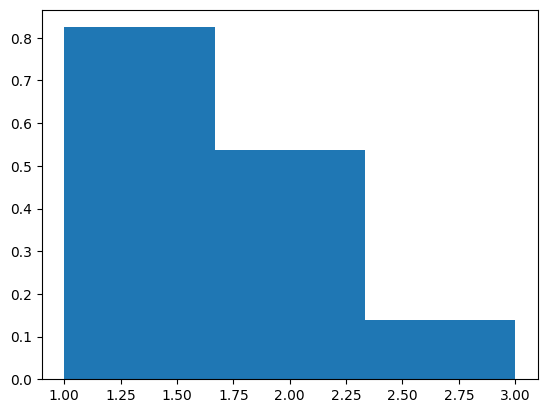

In [ ]:
plt.hist(y_test,bins = len(set(y_predicted))-1, density=True)

После преобразования данных методомснижения размерности через основные компоненты получили аккуратность незначительно выше, но главное у нас появился третий класс. И это уже радует. Таким образом модель улучшена.

Теперь, т.к. мы имеем предикторы в трёх степенях свободы, попробуем визуализировать и посмотреть визуально насколько реально классифицировать наши данные.

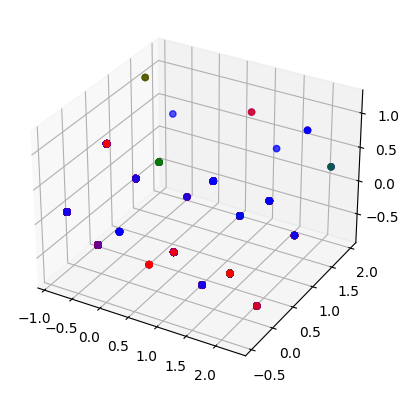

In [113]:
cmap = ListedColormap(['blue', 'red', 'green'])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter_plot = ax.scatter3D(X_test_pca.T[0], X_test_pca.T[1], X_test_pca.T[2],
                            c=y_test,
                            cmap=cmap)

Визуально пердикторы действительно разделяются на три класса.  
Полагаю, что лучшего результата нам не достичь на этих данных.  
Пробуем расширить рассматриваемые предикторы. Добавим в модель состояние дороги.

### Предсказание тяжести ДТП от погоды и сотояния дороги

Подготовим данные
Добавлю единственные предиктор, который пользователь может предоставить самомтоятельно. Определить его можно выглянув в окно.  
Сцепление с дорогой - Какое состояние дороги (гололёд - 0, заснеженная - 0 , мокрая - 1, сухая - 2)

In [114]:
X = geo_dtp_weather.sort_values('datetime')[['cloudly', 'rainfall', 'windy', 'light', 'road_grip']]
X.head(3)

cloudly  rainfall  windy light  road_grip
id                                                
2463903        0         0      0     0          2
2463801        1         0      0     1          0
2463902        1         0      0     3          1

In [115]:
X_train = X.head(int(len(X)*0.8))
X_test = X.tail(int(len(X)*0.2))
X_train.shape[0], X_test.shape[0]

(15024, 3756)

In [116]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
X_train_pca

(15024, 3)


array([[ 2.09885915, -0.48252875, -0.01603002],
       [ 1.19898181,  0.90029182,  1.71901125],
       [-0.81310179,  0.79860334,  0.74924973],
       ...,
       [ 1.10195718, -0.40398555, -0.01830689],
       [-0.89184677, -0.24689913, -0.02286063],
       [-0.83138143,  0.53982844, -0.21595805]])

In [117]:
# Нормируем полученные данные
X_train_pca = (X_train_pca - X_train_pca.min()) / (X_train_pca.max() - X_train_pca.min())
X_train_pca

array([[0.90879211, 0.12438033, 0.26613628],
       [0.63534449, 0.54458093, 0.79336693],
       [0.0239284 , 0.51368064, 0.49868345],
       ...,
       [0.60586141, 0.14824742, 0.2654444 ],
       [0.        , 0.1959816 , 0.26406065],
       [0.01837373, 0.43504616, 0.20538373]])

In [118]:
reg = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(X_train_pca, y_train.to_list())

In [119]:
y_predicted = reg.predict(X_test_pca)
y_predicted

array([2, 1, 1, ..., 1, 2, 2])

In [120]:
metrics.accuracy_score(y_test, y_predicted)

0.5207667731629393

In [123]:
metrics.r2_score(y_test, y_predicted)

-0.6990694747237534

(array([0.82468051, 0.53674121, 0.13857827]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <BarContainer object of 3 artists>)

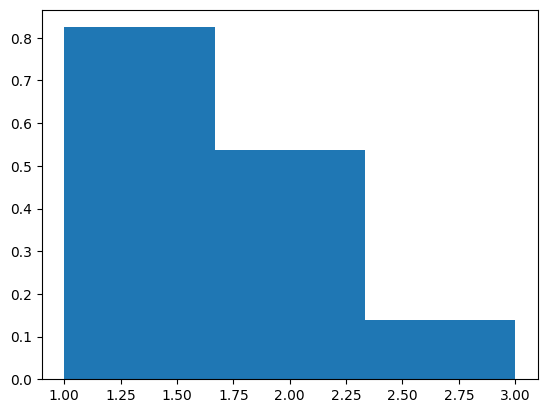

In [156]:
plt.hist(y_test,bins = len(set(y_predicted)), density=True)

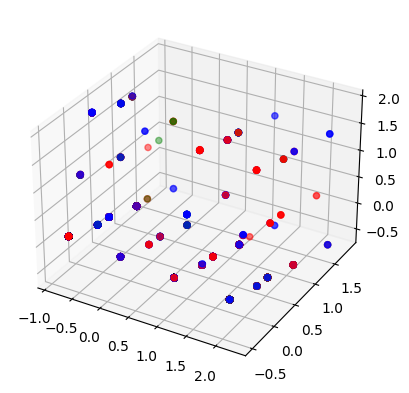

In [125]:
cmap = ListedColormap(['blue', 'red', 'green'])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter_plot = ax.scatter3D(X_test_pca.T[0], X_test_pca.T[1], X_test_pca.T[2],
                            c=y_test,
                            cmap=cmap)

### Обучение многослойной полносвязной сети

In [126]:
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from tqdm import tqdm

Модберём гиперпараметры сети. Используем изначальные данные (не PCA) 

In [127]:
X_train.columns

Index(['cloudly', 'rainfall', 'windy', 'light', 'road_grip'], dtype='object')

In [128]:
# Подберёи параметры для одного внутреннего слоя
params_score = {}
for k1 in tqdm(range(3,15)):
    mlp = MLPClassifier(random_state=80, 
                hidden_layer_sizes=(k1),
            )
    mlp.fit(X_train, y_train)
    y_mlp_pred = mlp.predict(X_test)
    if len(set(y_mlp_pred)) == 3: # Нам нужно выделить ровно три класса
        params_score[f'Для 1 сл. с кол. нейронов {k1}'] = \
            f'R2-score: {round(sklearn.metrics.r2_score(y_test, y_mlp_pred),3)}, ' + \
            f'Accuracy: {round(metrics.accuracy_score(y_test, y_mlp_pred),3)}'
params_score

100%|██████████| 12/12 [00:18<00:00,  1.55s/it]


{'Для 1 сл. с кол. нейронов 7': 'R2-score: -0.457, Accuracy: 0.541'}

In [ ]:
# Подберёи параметры для двух внутренних слойв

# search_list_params = [list(zip(range(3,15), [i]*12)) for i in range(3,10)]
# search_list_params = [element for sub_list in search_list_params for element in sub_list]
# # params_score = {}
# for k1, k2 in tqdm(search_list_params):
#     mlp = MLPClassifier(random_state=80, 
#                 hidden_layer_sizes=(k1,k2), # Используем два скрытых слоя и укажем число нейронов в каждом
#             )
#     mlp.fit(X_train, y_train)
#     y_mlp_pred = mlp.predict(X_test)
#     if len(set(y_mlp_pred)) == 3: # Нам нужно выделить ровно три класса
#         params_score[f'Для 2 сл. с кол. нейронов {k1} и {k2}'] = \
#             f'R2-score: {round(sklearn.metrics.r2_score(y_test, y_mlp_pred),3)}, ' + \
#             f'Accuracy: {round(metrics.accuracy_score(y_test, y_mlp_pred),3)}'
# params_score

![Подбор гиперпараметров](src/mlp_подбор_гипер-параметров.png)

Выбираем сеть с двумя скрытыми слоями с количеством нейронов 8 и 6

In [130]:
mlp = MLPClassifier(random_state=80, 
            hidden_layer_sizes=(8, 6), # Используем два скрытых слоя и укажем число нейронов в каждом
        )
mlp.fit(X_train, y_train)
y_mlp_pred = mlp.predict(X_test)

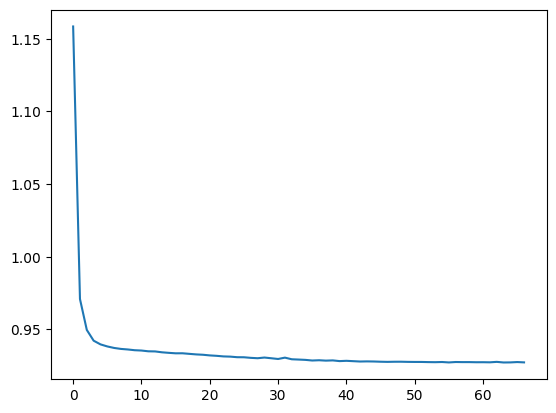

In [131]:
plt.plot(mlp.loss_curve_)

In [132]:
print(sklearn.metrics.classification_report(y_test, y_mlp_pred, digits=3))

              precision    recall  f1-score   support

           1      0.580     0.863     0.694      2065
           2      0.419     0.214     0.283      1344
           3      0.000     0.000     0.000       347

    accuracy                          0.551      3756
   macro avg      0.333     0.359     0.326      3756
weighted avg      0.469     0.551     0.483      3756



 Тренируем её на всей выборке

In [133]:
mlp.fit(X, y)

MLPClassifier(hidden_layer_sizes=(8, 6), random_state=80)

## Создание сервися для предсказания
На основе созданной модели создадим сервис онлайн для предсказания опасности ДТП по входным данным пользователя.  
Реализуем сервис с помощью телеграм-бота

1. Создадим бота с помощью [@botfather](https://t.me/botfather)  
<img src="src/telegram_bot_create.png" width="500">
2. Добавим описание  
<img src="src/telegram_bot_description.png" width="500">
3. Используем полученый токен 5865459696:AAG-zKYGaXGkXG_ib38H4bueg6-RkqqHfLU
4. Установка модуля telebot:  
$ pip install pyTelegramBotAPI  
5. За основу бота берём [готовые примеры](https://github.com/eternnoir/pyTelegramBotAPI/tree/master/examples)

Перейти к созданному боту можно по ссылке [@dtp_proba_bot](https://t.me/dtp_proba_bot)

Основа бота

In [134]:
import telebot
from telebot import types
from telebot.types import InlineKeyboardMarkup, InlineKeyboardButton

TOKEN = '5865459696:AAG-zKYGaXGkXG_ib38H4bueg6-RkqqHfLU'

knownUsers = []  # Список пользователей бота
# Здесь сохраняем текщий запрашиваемый пользователем пердиктор
# Облачно, дождливо, ветрено, светло и состояние дороги (гололёд, снег, мокрая, сухая)

def reqt_cloudly(cid):
    bot.send_message(cid, "Сейчас облачно?", reply_markup=gen_markup('YesNo'))
def req_rainfall(cid):
    bot.send_message(cid, "Сейчас есть осадки (дождь, снег)?", reply_markup=gen_markup('YesNo'))
def req_windy(cid):
    bot.send_message(cid, "Сейчас ветренно?", reply_markup=gen_markup('YesNo'))
def req_light(cid):
    bot.send_message(cid, "Сейчас светло?", reply_markup=gen_markup('YesNo'))
def req_road_grip(cid):
    bot.send_message(cid, "Какое сейчас состояние дороги?", reply_markup=gen_markup('Other'))

steps = {   'cloudly': reqt_cloudly,    # 0
            'rainfall': req_rainfall,   # 1
            'windy': req_windy,         # 2
            'light': req_light,         # 3
            'road_grip': req_road_grip  # 4
        }
userStep = {}    # номер cid: номер шага
userPredict = {} # Здесь сохраняются предикторы для предсказания
                 # cid: [0, 0, 0, 0, 0]

# Словарь команд бота
commands = {
    'start' : 'Начать использовать сервис',
    'help' : 'Вывести помощь',
    'new_predict' : 'Новое предсказание',
}

# Создаем экземпляр бота
bot = telebot.TeleBot(TOKEN)

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def command_start(m):
    cid = m.chat.id
    if cid not in knownUsers:   # Если пользователь ещё не известен:
        knownUsers.append(cid)  # Сохраним его user id
        bot.send_message(cid, "Здравия желаю! Капитан Петров слушает!")
        command_help(m)         # Показать справку
    else:
        bot.send_message(cid, "Здравия желаю! Мы уже знакомы.")


# Страница Помощи
@bot.message_handler(commands=['help'])
def command_help(m):
    help_text = "Могу выполнить следующие команды:\n"
    for key in commands:  # сгенерировать строку с командами из словаря commands, обозначеного в начале
        help_text += "/" + key + ": " + commands[key] + "\n"
    bot.send_message(m.chat.id, help_text)

# Кнопки для быстрого ответа
def gen_markup(layout='Other'):
    markup = InlineKeyboardMarkup()
    markup.row_width = 2
    if layout == 'YesNo':
        markup.add(
            InlineKeyboardButton("Да", callback_data="Да"),
            InlineKeyboardButton("Нет", callback_data="Нет")
        )
    else:
        markup.add(
            InlineKeyboardButton("Сухая", callback_data="Сухая"),
            InlineKeyboardButton("Мокрая", callback_data="Мокрая"),
            InlineKeyboardButton("Заснеженная", callback_data="Заснеженная"),
            InlineKeyboardButton("Гололёд", callback_data="Гололёд"),
        )
    return markup

# Функция записи ответа в переменную
@bot.callback_query_handler(func=lambda call: True)
def callback_query(call):
    cid = call.message.chat.id
    m = call.message
    ans = {
        'Нет': 0,
        'Да': 1,
        'Сухая': 2,
        'Мокрая': 1,
        'Заснеженная': 0,
        'Гололёд': 0,
    }
    if call.data in ans.keys():
        bot.edit_message_text(f'{m.text}\n\n{call.data}', cid, m.id) # Вписть ответ в сообщение, чтобы убрать кнопки
        userPredict[cid][userStep[cid]] = ans[call.data] # Запишем ответ
        if userStep[cid] < len(userPredict[cid])-1:
            userStep[cid] += 1
            process_next_steps(cid)
        else:
            pocess_predict(cid)


# Обработка коменды /new_predict 
# Первый шаг
@bot.message_handler(commands=['new_predict'])
def command_start(m):
    cid = m.chat.id
    if cid in knownUsers:
        userStep[cid] = 0   # Сохраним шаг, который предпринимается пользователем cid
        userPredict[cid] = [0] * len(steps.keys())
        list(steps.values())[0](cid)   # Вызов функции соответвующей 0 шагу
    else:
        bot.send_message(cid, "Что-то пошло не так. Запустите бот заново. /start")

# Следующие шаги
def process_next_steps(cid):
    list(steps.values())[userStep[cid]](cid)

# Стандартный ответ на любое сообщение
@bot.message_handler(content_types=['text'])
def command_default(m):
    bot.send_message(m.chat.id, "Ни-че-го не понимаю... /new_predict")


Функция предсказания и запуск бота [@dtp_proba_bot](https://t.me/dtp_proba_bot)

In [157]:
# Выдать результат
def pocess_predict(cid):
    # Предказание у нас ведётся по столбцу тяжесть аварии и выдёт значения от 1 до 3
    # Сделаем обратное преобразование
    slovar = {
        1: 'легкая',
        2: 'тяжёлая',
        3: 'с погибшими',
    }
    
    X_new = np.array([userPredict[cid]]).reshape(1, -1)
    y_mlp_pred_proba = dict(zip([1,2,3], mlp.predict_proba(X_new)[0]))
    y_mlp_pred_proba = dict_sort(y_mlp_pred_proba)
    ans = 'Вангую вероятность!\n\n'
    for k,v in y_mlp_pred_proba.items():
        ans += f'{int(v*100)}% {slovar[k]}\n'
    print(cid, ans)
    ans += '\nПопробовать ещё: /new_predict'
    bot.send_message(cid, ans)

# Запускаем бота
bot.polling(none_stop=True, interval=0)

c:\Users\work\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


350211504 Вангую вероятность!

43% тяжёлая
31% с погибшими
24% легкая

